In [21]:
""" Take from plot_coldeurasia_ts.ipynb
    Feb. 19, 2106
    
    Repeat a bunch of the Kug et al. 2015 analysis w/ obs and LE
    
"""
import cccmaplots as cplt
import cccmaNC as cnc
import cccmautils as cutl
import constants as con
import cccmacmaps as ccm
import platform as platform
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import numpy.ma as ma

%matplotlib inline

con=reload(con)


# SET UP DATA
#timesel='1979-01-01,2015-07-01'
#timesel='1979-01-01,2014-12-31'

obspath= '/HOME/rkm/work/DATA/'
obspath2 = '/HOME/rkm/work/BCs/'

graveraint= 9.80665 # m/s2 (different from Canadian models)

regionskug = {'EUR': 'eurasiakug',
           'BKS': 'bkskug',
           'CHUCK': 'chuckkug',
           'NA':'nthamkug'}
# repeat w/ my regions
#regionskug = {'EUR': 'eurasiamori',
#           'BKS': 'bksmori',
#           'CHUCK': 'chuckkug',
#           'NA':'nthamkug'}


# reproduce Kug et al. 2015 analysis 2/17/2016
fnameskug={'sat': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_st.001_1979011612-2015121612.nc',
           'z500': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_phi500.001_1979011612-2015121612.nc',
           'z300': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_phi300.nc',
           'slp': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_pmsl.001_1979011612-2015121612.nc',
           'sic': obspath2 + 'NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc' }

fnamesdaykug ={'sat': obspath + 'ERAINT/td_era_int_197901_latest_dp_128_64_st.nc'}


fieldskug={'sat': 'ST',
           'z500': 'PHI',
           'z300': 'PHI',
           'slp': 'PMSL',
           'sic': 'SICN'}
convskug = {'sat': 1,
         'z500': 1/graveraint,
         'z300': 1/graveraint,
         'slp': 1,
         'sic': 100}



In [2]:
def runmean(input, window=5,axis=0) :
    ret = np.cumsum(input, dtype=float,axis=axis)
    ret[window:,...] = ret[window:,...] - ret[:-window,...]
    return ret[window - 1:,...] / np.float(window)


def selectmonths(input,start=0, incr=3, weights=(0.34444444,0.34444444,0.31111111),
                 retavg=False):
    """ choose selected months but repeat until end of time dim (assume axis=0!!)
        This is for a monthly average dataset!
        
            retavg: a flag to specify whether the average of the chosen months
                    should be returned instead of the individual months
                    For example, if True, if selected months are D,J,F then 
                       timeseries of DJF means will be returned instead of D,J,F repeating
            weights are for D,J,F average into DJF seasonal mean
            
            returns either array of D,J,F OR array of DJF mean
            
    """
    nt = input.shape[0]
    #nyrs = nt/12
    rem = np.mod((nt-start),12)
    nyrs = (nt-start)/12
    print 'nyrs,remainder ' + str(nyrs),str(rem)
    if rem>=incr:
        nyrs=nyrs+1
        
    print 'nyrs ' + str(nyrs)
    
    ntout = nyrs*incr # leave off trailing months if they exist. @@@ works only if first idx is 0??
    
    #print type(input[0])
    
    if input.ndim>1:
        otherdims=input.shape[1:]
    else:
        print 'selectmonths() on 1-D not supported @@@@'
        otherdims=()
        #return -1
    
    if 'datetime' in str(type(input[0])) :
        ret=[]
    else:
        if retavg:
            ret = np.zeros((nyrs,)+otherdims)
        else:
            ret = np.zeros((ntout,)+otherdims) #input.shape[1],input.shape[2]))

        print 'ret.shape ' + str(ret.shape)
    print 'nyrs ' + str(nyrs) + ', and ' + str(ntout/incr)
    
    for yridx in range(0,nyrs):
        subsamp = range(start+yridx*12,start+yridx*12+incr)
        #print yridx, subsamp # @@@
        if retavg:
            ret[yridx,...] = np.average(input[subsamp,...],weights=np.array(weights),axis=0)
        else:
            if 'datetime' in str(type(input[0])): # hack to check dates that are selected               
                ret[yridx*incr:yridx*incr+incr] = input[subsamp]
                
            else: # hack to check dates that are selected
                
                ret[yridx*incr:yridx*incr+incr,...] = input[subsamp,...]  
        
        #print 'input[subsamp,...].shape ' + str(input[subsamp,...].shape)

    return ret

def rem_monmean(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          removes the climatological monthly mean from a timeseries that
              does not include all months. 
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                         
              returns a tuple: timeseries w/ climo removed, the tiled climo that was removed      
    """
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'nyr ' + str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        oshape = tuple(np.ones(len(otherdims)))
        tshape = (nyr,)+oshape # tile shape
        remclimo = np.zeros((incr,)+otherdims) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
    else:
        tshape = (nyr,) # tile shape
        remclimo = np.zeros((incr)) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'removing ' + str(np.mean(input[midx::incr,...],axis=0))
        remclimo[midx,...] = np.mean(input[midx::incr,...],axis=0)
        
    
    remclimot=np.tile(remclimo,tshape) # tile the climo for number of years
    print 'remclimot.shape ' + str(remclimot.shape)
    
    
    inrem = input - remclimot
    
    return inrem,remclimot

def detrend_monthly(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          detrends on a monthly basis, when input is a timeseries that
              does not include all months. (It could, haven't tried)
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                         
              returns: detrended timeseries w/ shape the same as input
    """
    
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'nyr ' + str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        retdtr = np.zeros((ntime,)+otherdims) # detrended data
        print 'retdtr.shape ' + str(retdtr.shape)
    else:
        retdtr = np.zeros((ntime)) # detrended data
        #print 'retdtr.shape ' + str(retdtr.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'detrending ' + str(np.mean(input[midx::incr,...],axis=0))
        retdtr[midx::incr,...] = cutl.detrend(input[midx::incr,...],axis=0)
        #@@input[midx::incr,...] = cutl.detrend(input[midx::incr,...],axis=0)
        
    return retdtr
    

# calculate regressions w/ space
def corrmap(inr,insp,dims):
    """   
          inr is 1D [time or numens]
          insp is 2D [time or numens x space.flat]
          dims are a tuple of dims to reshape space to (nlat,nlon) 

          returns slopemap,corrmap,pvalmap [dims]           
    """ 
    #print inr.shape, insp.shape
    
    mm,bb,rval,pval = cutl.regress(inr,insp)
    #slope,intercept = np.polyfit(inr,insp, 1)
    corrmap = rval.reshape(dims)
    pvmap = pval.reshape(dims)
    slopemap = mm.reshape(dims)
    
    return slopemap,corrmap,pvmap


def load_field(fdict,casename,timesel,seas=None,mo=0,ftype='fullts',orig=None,calc=None,conv=1,local=False,verb=False):
    
    """ TAKEN FROM load_field() in canesm_le_composite.py/pi_pdf_uncertainty.py

        returns [numens x space.flat] or [numens]

    """

    ledat = le.load_LEdata(fdict,casename,timesel=timesel, 
                           rettype='ndarray',conv=conv,ftype=ftype,orig=orig,local=local,verb=verb)

    # time needs to be first dimension
    try:
        if ledat.ndim==2:
            ledat = ledat.T
        elif ledat.ndim==3:
            ledat = np.transpose(ledat,(1,0,2))
        else:
            print 'Loaded data is not 2 or 3 dimensions. Do not understand.'
            raise Exception
    except:
        raise

    # @@@@ note there was an error here, I think, copied from le_sic_vs_tas notebook 2/19/2016
    # @@@@ There was no check for if sea was set, and calc='trend'. it would be incorrect.
    
    if seas==None and mo==0:
        lesea=ledat
        if calc!=None and calc=='trend':
            mm,bb=cutl.trend_monthly(ledat) # should return 12 x numens x space.flat
            return lesea,mm,bb
        else:
            return lesea
    else:
        lesea = cutl.seasonalize(ledat,season=seas,mo=mo) # time x numens x space.flat

        if calc!=None and calc=='trend':
            mm,bb=cutl.trend(lesea) # should return numens x space.flat
            return lesea,mm,bb
        else:
            return lesea


lat: squeezing data upon read all
lon: squeezing data upon read all
(34, 64, 129)
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
(34,)
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)


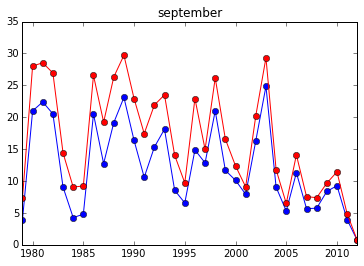

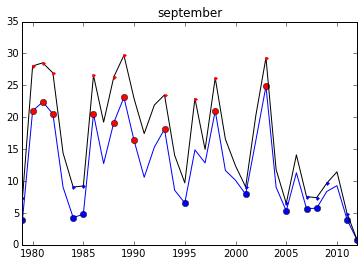

In [3]:
# TEST SIC boundary forcing versus other papers
cutl=reload(cutl)

timeselmori = '1979-01-01,2013-02-31' # @@@@ go through winter of 12/13?

# this is the dataset that we use for BC
sicmccsep = cnc.getNCvar(fnameskug['sic'],fieldskug['sic'],timesel=timeselmori,monsel=9)*100
latsic = cnc.getNCvar(fnameskug['sic'],'lat')
lonsic = cnc.getNCvar(fnameskug['sic'],'lon')
print sicmccsep.shape # should be 34 yrs
sicbksmccsep = cutl.calc_regmean(sicmccsep,latsic,lonsic,'bksmori',model=None,alsomask='land')
print sicbksmccsep.shape # should be 34 yrs

# Mori et al. use HadISST I think
hadname = obspath2 + '/HadISST/hadisst1.1_bc_128_64_1870_2013m03_sicn_1870010100-2013030100.nc'
hsicmorisep = cnc.getNCvar(hadname,fieldskug['sic'],timesel=timeselmori,monsel=9)*100
hlatsic = cnc.getNCvar(hadname,'lat')
hlonsic = cnc.getNCvar(hadname,'lon')
hsicbksmorisep = cutl.calc_regmean(hsicmorisep,hlatsic,hlonsic,'bksmori',model=None,alsomask='land')




xxsic = np.arange(1979,1979+len(hsicbksmorisep))
plt.figure()
plt.plot(xxsic,hsicbksmorisep,marker='o')
plt.plot(xxsic,sicbksmccsep,marker='o',color='r')
plt.ylim((0,35))
plt.xlim((1979,2012))
plt.title('september')

# choose high and low 10
nn=10
hhighidx = (-hsicbksmorisep).argsort()[:nn]
hlowidx = hsicbksmorisep.argsort()[:nn]

highidx = (-sicbksmccsep).argsort()[:nn]
lowidx = sicbksmccsep.argsort()[:nn]

plt.figure()
plt.plot(xxsic,hsicbksmorisep,color='b')
plt.plot(xxsic[hhighidx],hsicbksmorisep[hhighidx],marker='o',color='r',linestyle='none')
plt.plot(xxsic[hlowidx],hsicbksmorisep[hlowidx],marker='o',color='b',linestyle='none')

plt.plot(xxsic,sicbksmccsep,color='k')
plt.plot(xxsic[highidx],sicbksmccsep[highidx],marker='.',color='r',linestyle='none')
plt.plot(xxsic[lowidx],sicbksmccsep[lowidx],marker='.',color='b',linestyle='none')
plt.ylim((0,35))
plt.xlim((1979,2012))
plt.title('september')

In [4]:
# Now get all months and show SON and DJF of the min vs max years

cutl=reload(cutl)
con=reload(con)


hsicmori = cnc.getNCvar(hadname,fieldskug['sic'],timesel=timeselmori)*100
sonwgts=np.array([30, 31, 30]) / 91.
print sonwgts

hsicmorison = selectmonths(hsicmori,start=8,incr=3,weights=sonwgts,retavg=True)
print hsicmorison.shape
hsicmorisonhi = hsicmorison[highidx,...].mean(axis=0)
hsicmorisonlo = hsicmorison[lowidx,...].mean(axis=0)

hsicmoridjf = selectmonths(hsicmori,start=11,incr=3,retavg=True)
print hsicmoridjf.shape
hsicmoridjfhi = hsicmoridjf[highidx,...].mean(axis=0)
hsicmoridjflo = hsicmoridjf[lowidx,...].mean(axis=0)


# test land mask
hsicmorisonhi,_ = cutl.mask_t63land(hsicmorisonhi)
hsicmorisonlo,_ = cutl.mask_t63land(hsicmorisonlo)
hsicmoridjfhi,_ = cutl.mask_t63land(hsicmoridjfhi)
hsicmoridjflo,_ = cutl.mask_t63land(hsicmoridjflo)

timeselmcc1 = '1979-01-01,1989-12-31' 
timeselmcc2 = '2002-01-01,2012-12-31' 

sicmcc1djf = (cnc.getNCvar(fnameskug['sic'],fieldskug['sic'],timesel=timeselmcc1,seas='DJF')*100).mean(axis=0)
sicmcc1son = (cnc.getNCvar(fnameskug['sic'],fieldskug['sic'],timesel=timeselmcc1,seas='SON')*100).mean(axis=0)
sicmcc2djf = (cnc.getNCvar(fnameskug['sic'],fieldskug['sic'],timesel=timeselmcc2,seas='DJF')*100).mean(axis=0)
sicmcc2son = (cnc.getNCvar(fnameskug['sic'],fieldskug['sic'],timesel=timeselmcc2,seas='SON')*100).mean(axis=0)

print sicmcc1djf.shape,sicmcc1son.shape

[ 0.32967033  0.34065934  0.32967033]
nyrs,remainder 33 6
nyrs 34
ret.shape (34, 64, 129)
nyrs 34, and 34
(34, 64, 129)
nyrs,remainder 33 3
nyrs 34
ret.shape (34, 64, 129)
nyrs 34, and 34
(34, 64, 129)
(64, 129) (64, 129)


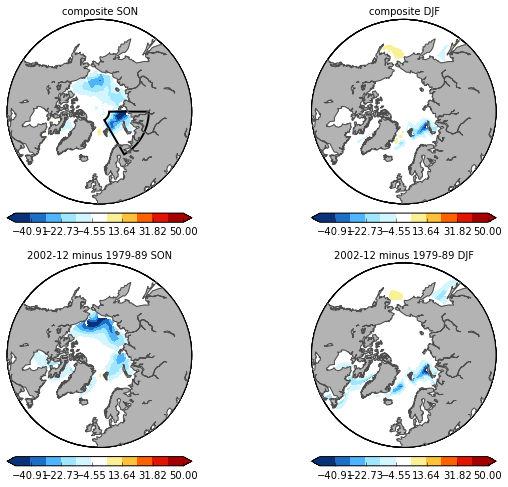

In [5]:
printtofile=False

cmin=-50; cmax=50; cmap='blue2red_w11'
latlim=45

pparams = {'latlim':latlim,'cmin':cmin,'cmax':cmax,'cmap':cmap,
           'ptype':'nheur','lmask':True}

fig,axs = plt.subplots(2,2,figsize=(10,8))
ax=axs[0,0]
bm,pc = cplt.kemmap(hsicmorisonlo-hsicmorisonhi,hlatsic,hlonsic,axis=ax,
            title='composite SON',**pparams)
cplt.add_regionpolym('bksmori',bm)
ax=axs[0,1]
bm,pc =cplt.kemmap(hsicmoridjflo-hsicmoridjfhi,hlatsic,hlonsic,axis=ax,
            title='composite DJF',**pparams)
# @@@ nheur not working? @@@
#cplt.add_regionpolym('bksmori',bm)

#fig,axs = plt.subplots(1,2,figsize=(10,4))
ax=axs[1,0]
cplt.kemmap(sicmcc2son-sicmcc1son,latsic,lonsic,axis=ax,
            title='2002-12 minus 1979-89 SON',**pparams)
ax=axs[1,1]
cplt.kemmap(sicmcc2djf-sicmcc1djf,latsic,lonsic,axis=ax,
            title='2002-12 minus 1979-89 DJF',**pparams)
if printtofile:
    fig.savefig('Mori_McCuskeretal_SON_DJF_obsSICbcs.pdf')

    


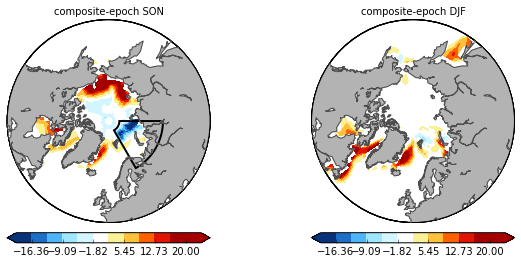

In [6]:
cmin=-20; cmax=20;     
pparams['cmin'] = cmin
pparams['cmax'] = cmax

fig,axs = plt.subplots(1,2,figsize=(10,4))    
ax=axs[0]
bm,pc = cplt.kemmap((hsicmorisonlo-hsicmorisonhi) - (sicmcc2son-sicmcc1son),hlatsic,hlonsic,axis=ax,
            title='composite-epoch SON',**pparams)
cplt.add_regionpolym('bksmori',bm)
ax=axs[1]
cplt.kemmap((hsicmoridjflo-hsicmoridjfhi)-(sicmcc2djf-sicmcc1djf),hlatsic,hlonsic,axis=ax,
            title='composite-epoch DJF',**pparams)
if printtofile:
    fig.savefig('Mori_McCuskeretal_SON_DJF_obsSICbcs_diff.pdf')

In [7]:
lecomp=True
import loadLE as le

if lecomp:
    casename='historical'
    
    
    # here we will choose the high and low Sept ice for each ensemble member
    # then use those years to make composites
    # My question is, is the pattern as non-uniform across the basin as in
    #   observations (the Mori dataset)? Does the LE capture this type of
    #   spacially diverse sea ice loss?
    
    
    compsel=timeselmori
    bdt = {'field': 'siabksmori', 'ncfield': 'siabksmori', 'comp': 'OImon'}
    adt = {'field': 'sianh', 'ncfield': 'sianh', 'comp': 'OImon'}
    conv=1/1e12
    
    # mo x ens
    lebkssep = load_field(bdt,casename,timesel=compsel, conv=conv,
                    ftype='fullts',local=True,verb=False,mo=9)
    lebksson = load_field(bdt,casename,timesel=compsel, conv=conv,
                    ftype='fullts',local=True,verb=False,seas='SON')
    lebksdjf = load_field(bdt,casename,timesel=compsel, conv=conv,
                    ftype='fullts',local=True,verb=False,seas='DJF')
    learcson = load_field(adt,casename,timesel=compsel, conv=conv,
                    ftype='fullts',local=True,verb=False,seas='SON')
    learcdjf = load_field(adt,casename,timesel=compsel, conv=conv,
                    ftype='fullts',local=True,verb=False,seas='DJF')    
    print lebkssep.shape
    
    
    # choose high and low 10
    nn=10
    lehighidx = (-lebkssep).argsort(axis=0)[:nn,:]
    lelowidx = lebkssep.argsort(axis=0)[:nn,:]
    
    print lehighidx.shape


(50, 410)
(50, 410)
(50, 410)
(50, 410)
(50, 410)
(50, 410)
(50, 410)
(50, 410)
(50, 410)
(50, 410)
(34, 50)
(10, 50)


(34, 50)


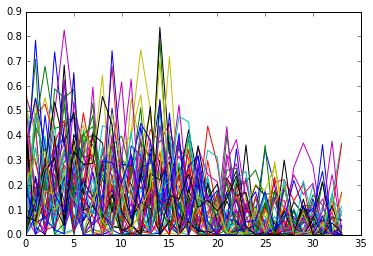

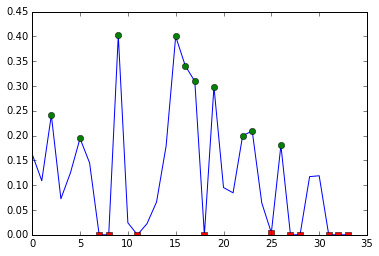

In [8]:
if lecomp:
    
    # load LE data and choose high and low ice based on Sept BKS ice (as Mori et al)
    
    lexx = np.arange(0,lebkssep.shape[0])
    plt.figure()
    plt.plot(lebkssep)
    
    plt.figure()
    plt.plot(lexx,lebkssep[:,2])
    plt.plot(lexx[lehighidx[:,2]],lebkssep[lehighidx[:,2],2],marker='o',linestyle='none')
    plt.plot(lexx[lelowidx[:,2]],lebkssep[lelowidx[:,2],2],marker='s',linestyle='none')
    
    print lebksson.shape
    
    
    #lehison = lebksson[lehighidx] # can't figure out how to multi-dim choose indices
    #  will have to loop
    leloson=np.zeros(lehighidx.shape[1]); lehison=np.zeros(lehighidx.shape[1])
    lelodjf=np.zeros(lehighidx.shape[1]); lehidjf=np.zeros(lehighidx.shape[1])
    leloarcson=np.zeros(lehighidx.shape[1]); lehiarcson=np.zeros(lehighidx.shape[1])
    leloarcdjf=np.zeros(lehighidx.shape[1]); lehiarcdjf=np.zeros(lehighidx.shape[1])
    for ii in np.arange(0,len(leloson)):
        
        hi = lehighidx[:,ii]
        lo = lelowidx[:,ii]
        
        lehison[ii] = lebksson[hi,ii].mean(axis=0)
        leloson[ii] = lebksson[lo,ii].mean(axis=0)
        lehidjf[ii] = lebksdjf[hi,ii].mean(axis=0)
        lelodjf[ii] = lebksdjf[lo,ii].mean(axis=0)
        lehiarcson[ii] = learcson[hi,ii].mean(axis=0)
        leloarcson[ii] = learcson[lo,ii].mean(axis=0)
        lehiarcdjf[ii] = learcdjf[hi,ii].mean(axis=0)
        leloarcdjf[ii] = learcdjf[lo,ii].mean(axis=0)
    
    


In [9]:
# Now compare to model BC's
import loadmodeldata as lmd
cutl=reload(cutl)

dosia=True # this will calc BKS sea ice area to compare w/ arctic SIE
           # Otherwise just calc BKS SIC

latsim = con.get_t63lat()
lonsim = con.get_t63lon()

sims=('R1','R2','R3','R4','R5')
#sims=('E1','E2','E3','E4','E5')

field='sic'

simconv1=1
if field=='tas': simfield1='st'; simncfield1='ST'
elif field=='zg50000.00': simfield1='gz50000'; simncfield1='PHI'; simconv1=1/con.get_g()
elif field=='sia': simfield1='sicn'; simncfield1='SICN'; print '@@ danger, sia actually sicn average'
elif field=='sic': simfield1='sicn'; simncfield1='SICN'; simconv1=100
else: print 'cannot addsims for ' + field;

siccdf = lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly', 
                      filetype='ctl')#*simconv1
print siccdf.keys()
nlatsim = len(latsim)
nlonsim = len(lonsim)

sicpdf = lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly', 
                      filetype='pert')#*simconv1

print lonsim.shape

siccson={}; siccdjf={}; sicpson={}; sicpdjf={} 
sicbkscson={}; sicbkscdjf={}; sicbkspson={}; sicbkspdjf={} 
sicarccson={}; sicarccdjf={}; sicarcpson={}; sicarcpdjf={} 

for eii,ekey in enumerate(sims):
    
    print ekey
    spsicc = siccdf[ekey]
    print spsicc.shape
        
    siccson[ekey] = selectmonths(spsicc,start=8,incr=3,weights=sonwgts,retavg=True).mean(axis=0)*simconv1
    siccdjf[ekey] = selectmonths(spsicc,start=11,incr=3,retavg=True).mean(axis=0)*simconv1

    if dosia:
        sicbkscson[ekey] = cutl.calc_regtotseaicearea(siccson[ekey]/100.,latsic,lonsic,'bksmori',
                                                      isarea=False,model=None,alsomask='land')
        sicbkscdjf[ekey] = cutl.calc_regtotseaicearea(siccdjf[ekey]/100.,latsic,lonsic,'bksmori',
                                                      isarea=False,model=None,alsomask='land')# don't know if I need to mask lnd too
    else:
        sicbkscson[ekey] = cutl.calc_regmean(siccson[ekey],latsic,lonsic,'bksmori',model=None,alsomask='land')
        sicbkscdjf[ekey] = cutl.calc_regmean(siccdjf[ekey],latsic,lonsic,'bksmori',model=None,alsomask='land')

    sicarccson[ekey],_=cutl.calc_totseaicearea(siccson[ekey]/100.,latsic,lon=lonsic,model=None)
    sicarccdjf[ekey],_=cutl.calc_totseaicearea(siccdjf[ekey]/100.,latsic,lon=lonsic,model=None)
    
    spsicp = sicpdf[ekey]
    print spsicp.shape
        
    sicpson[ekey] = selectmonths(spsicp,start=8,incr=3,weights=sonwgts,retavg=True).mean(axis=0)*simconv1
    sicpdjf[ekey] = selectmonths(spsicp,start=11,incr=3,retavg=True).mean(axis=0)*simconv1

    if dosia:
        sicbkspson[ekey] = cutl.calc_regtotseaicearea(sicpson[ekey]/100.,latsic,lonsic,'bksmori',
                                                      isarea=False,model=None,alsomask='land')
        sicbkspdjf[ekey] = cutl.calc_regtotseaicearea(sicpdjf[ekey]/100.,latsic,lonsic,'bksmori',
                                                      isarea=False,model=None,alsomask='land')
    else:
        sicbkspson[ekey] = cutl.calc_regmean(sicpson[ekey],latsic,lonsic,'bksmori',model=None,alsomask='land')
        sicbkspdjf[ekey] = cutl.calc_regmean(sicpdjf[ekey],latsic,lonsic,'bksmori',model=None,alsomask='land')
    
    sicarcpson[ekey],_=cutl.calc_totseaicearea(sicpson[ekey]/100.,latsic,lon=lonsic,model=None)
    sicarcpdjf[ekey],_=cutl.calc_totseaicearea(sicpdjf[ekey]/100.,latsic,lon=lonsic,model=None)
    


lat: squeezing data upon read all
lon: squeezing data upon read all
@@ probably should invert the order such that it is field, season, sim?
('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
sicn SICN
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_sicn_001-121_ts.nc
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_sicn_001-121_ts.nc
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_sicn_001-121_ts.nc
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_sicn_001-121_ts.nc
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_sicn_001-121_ts.nc
['R4', 'R5', 'R1', 'R2', 'R3']
@@ probably should invert the order such that it is field, season, sim?
('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
sicn SICN
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_sicn_001-121_ts.nc
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_sicn_001-121_ts.nc
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_sicn_001-1

In [10]:
if dosia:
    sicbkspson['Mori obs'] = cutl.calc_regtotseaicearea(hsicmorisonlo/100.,hlatsic,hlonsic,'bksmori',
                                                        isarea=False,model=None,alsomask='land')
    sicbkscson['Mori obs'] = cutl.calc_regtotseaicearea(hsicmorisonhi/100.,hlatsic,hlonsic,'bksmori',
                                                        isarea=False,model=None,alsomask='land')
    sicbkspdjf['Mori obs'] = cutl.calc_regtotseaicearea(hsicmoridjflo/100.,hlatsic,hlonsic,'bksmori',
                                                        isarea=False,model=None,alsomask='land')
    sicbkscdjf['Mori obs'] = cutl.calc_regtotseaicearea(hsicmoridjfhi/100.,hlatsic,hlonsic,'bksmori',
                                                        isarea=False,model=None,alsomask='land')
    sicbkspson['McC obs']=cutl.calc_regtotseaicearea(sicmcc2son/100.,latsic,lonsic,'bksmori',
                                                     isarea=False,model=None,alsomask='land')
    sicbkscson['McC obs']=cutl.calc_regtotseaicearea(sicmcc1son/100.,latsic,lonsic,'bksmori',
                                                     isarea=False,model=None,alsomask='land')
    sicbkspdjf['McC obs']=cutl.calc_regtotseaicearea(sicmcc2djf/100.,latsic,lonsic,'bksmori',
                                                     isarea=False,model=None,alsomask='land')
    sicbkscdjf['McC obs']=cutl.calc_regtotseaicearea(sicmcc1djf/100.,latsic,lonsic,'bksmori',
                                                     isarea=False,model=None,alsomask='land')
    
else:
    sicbkspson['Mori obs']=cutl.calc_regmean(hsicmorisonlo,hlatsic,hlonsic,'bksmori',model=None,alsomask='land')
    sicbkscson['Mori obs']=cutl.calc_regmean(hsicmorisonhi,hlatsic,hlonsic,'bksmori',model=None,alsomask='land')
    sicbkspdjf['Mori obs']=cutl.calc_regmean(hsicmoridjflo,hlatsic,hlonsic,'bksmori',model=None,alsomask='land')
    sicbkscdjf['Mori obs']=cutl.calc_regmean(hsicmoridjfhi,hlatsic,hlonsic,'bksmori',model=None,alsomask='land')

    sicbkspson['McC obs']=cutl.calc_regmean(sicmcc2son,latsic,lonsic,'bksmori',model=None,alsomask='land')
    sicbkscson['McC obs']=cutl.calc_regmean(sicmcc1son,latsic,lonsic,'bksmori',model=None,alsomask='land')
    sicbkspdjf['McC obs']=cutl.calc_regmean(sicmcc2djf,latsic,lonsic,'bksmori',model=None,alsomask='land')
    sicbkscdjf['McC obs']=cutl.calc_regmean(sicmcc1djf,latsic,lonsic,'bksmori',model=None,alsomask='land')

# full arctic sea ice area
sicarcpson['Mori obs'],_=cutl.calc_totseaicearea(hsicmorisonlo/100.,hlatsic,lon=hlonsic,model=None)
sicarccson['Mori obs'],_=cutl.calc_totseaicearea(hsicmorisonhi/100.,hlatsic,lon=hlonsic,model=None)
sicarcpdjf['Mori obs'],_=cutl.calc_totseaicearea(hsicmoridjflo/100.,hlatsic,lon=hlonsic,model=None)
sicarccdjf['Mori obs'],_=cutl.calc_totseaicearea(hsicmoridjfhi/100.,hlatsic,lon=hlonsic,model=None)

sicarcpson['McC obs'],_=cutl.calc_totseaicearea(sicmcc2son/100.,latsic,lon=lonsic,model=None)
sicarccson['McC obs'],_=cutl.calc_totseaicearea(sicmcc1son/100.,latsic,lon=lonsic,model=None)
sicarcpdjf['McC obs'],_=cutl.calc_totseaicearea(sicmcc2djf/100.,latsic,lon=lonsic,model=None)
sicarccdjf['McC obs'],_=cutl.calc_totseaicearea(sicmcc1djf/100.,latsic,lon=lonsic,model=None)


print sicbkspson
print sicbkscson

{'R4': 281759935147.35309, 'R5': 395338483490.31842, 'R1': 200245864061.8667, 'R2': 364535935600.61963, 'R3': 232731253775.51508, 'McC obs': 537265052197.14648, 'Mori obs': 386887324857.47656}
{'R4': 401430964013.68115, 'R5': 553530338673.19641, 'R1': 424122885275.03821, 'R2': 531642128313.95111, 'R3': 575958529158.34277, 'McC obs': 801391374137.27637, 'Mori obs': 776130932218.31079}


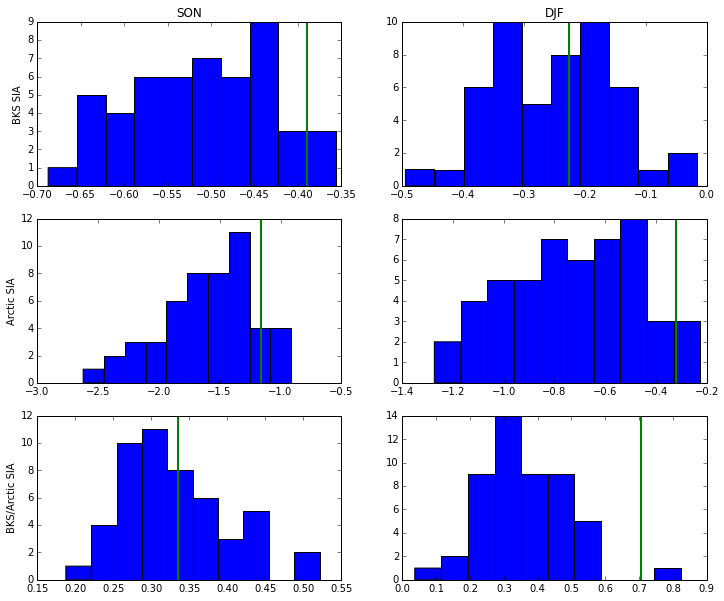

In [11]:

# here the LE comparisons have been chosen based on 
# compositing on BKS september ice w/in each ensemble member
#    Add the Mori composite.
if lecomp:
    
    printtofile=False
    
    
    fig,axs= plt.subplots(3,2,figsize=(12,10))
    ax=axs[0,0]
    ax.hist(leloson-lehison)
    ax.axvline((sicbkspson['Mori obs']-sicbkscson['Mori obs'])/1e12,color='g',linewidth=2)
    ax.set_ylabel('BKS SIA')
    ax.set_title('SON')
    ax=axs[0,1]
    ax.hist(lelodjf-lehidjf)
    ax.axvline((sicbkspdjf['Mori obs']-sicbkscdjf['Mori obs'])/1e12,color='g',linewidth=2)
    ax.set_title('DJF')

    ax=axs[1,0]
    ax.hist(leloarcson-lehiarcson)
    ax.axvline((sicarcpson['Mori obs']-sicarccson['Mori obs'])/1e12,color='g',linewidth=2)
    ax.set_ylabel('Arctic SIA')
    ax=axs[1,1]
    ax.hist(leloarcdjf-lehiarcdjf)
    ax.axvline((sicarcpdjf['Mori obs']-sicarccdjf['Mori obs'])/1e12,color='g',linewidth=2)
    
    ax=axs[2,0]
    ax.hist((leloson-lehison)/(leloarcson-lehiarcson))
    ax.axvline((sicbkspson['Mori obs']-sicbkscson['Mori obs'])/(sicarcpson['Mori obs']-sicarccson['Mori obs']),
               color='g',linewidth=2)
    ax.set_ylabel('BKS/Arctic SIA')
    ax=axs[2,1]
    ax.hist((lelodjf-lehidjf)/(leloarcdjf-lehiarcdjf))
    ax.axvline((sicbkspdjf['Mori obs']-sicbkscdjf['Mori obs'])/(sicarcpdjf['Mori obs']-sicarccdjf['Mori obs']),
               color='g',linewidth=2)
    if printtofile:
        fig.savefig('LEobsMori_BKSArctic_SIAchgratio_hist_SONDJF_componSepBKS.pdf')
    

In [12]:

# here just read in the seasonal LE averages (rather than compositing as above)
#   time periods are as used in the paper
if not dosia:
    bdt = {'field': 'sicbksmori', 'ncfield': 'sic', 'comp': 'OImon'}
    adt = {'field': 'sicnh', 'ncfield': 'sic', 'comp': 'OImon'}
    conv=1
    ttl = 'SIC'
else:
    bdt = {'field': 'siabksmori', 'ncfield': 'siabksmori', 'comp': 'OImon'}
    adt = {'field': 'sianh', 'ncfield': 'sianh', 'comp': 'OImon'}
    conv=1/1e12
    ttl = 'SIA'
    
# seas x ens
tmpc = load_field(bdt,casename,timesel=timeselmcc1, conv=1,
                ftype='fullts',local=True,verb=False,seas='DJF').mean(axis=0)
tmpp = load_field(bdt,casename,timesel=timeselmcc2,conv=1,
                ftype='fullts',local=True,verb=False,seas='DJF').mean(axis=0)
tmparcc = load_field(adt,casename,timesel=timeselmcc1, conv=1,
                    ftype='fullts',local=True,verb=False,seas='DJF').mean(axis=0)
tmparcp = load_field(adt,casename,timesel=timeselmcc2,conv=1,
                    ftype='fullts',local=True,verb=False,seas='DJF').mean(axis=0)

tmpcs = load_field(bdt,casename,timesel=timeselmcc1, conv=1,
                ftype='fullts',local=True,verb=False,seas='SON').mean(axis=0)
tmpps = load_field(bdt,casename,timesel=timeselmcc2,conv=1,
                ftype='fullts',local=True,verb=False,seas='SON').mean(axis=0)
tmparccs = load_field(adt,casename,timesel=timeselmcc1, conv=1,
                    ftype='fullts',local=True,verb=False,seas='SON').mean(axis=0)
tmparcps = load_field(adt,casename,timesel=timeselmcc2,conv=1,
                    ftype='fullts',local=True,verb=False,seas='SON').mean(axis=0)

print tmpc.shape 
print tmpp.shape

(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50,)
(50,)


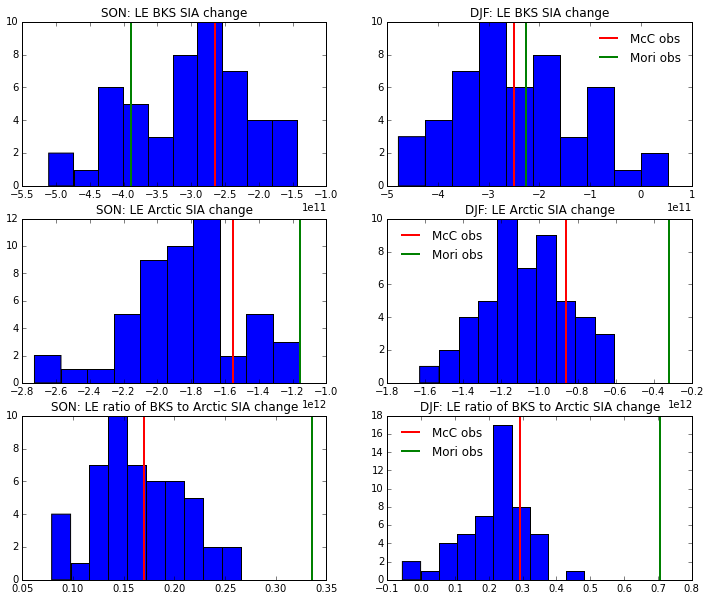

In [13]:
mccbsdiff = sicbkspson['McC obs'] - sicbkscson['McC obs']
mccasdiff = sicarcpson['McC obs'] - sicarccson['McC obs']
morbsdiff = sicbkspson['Mori obs'] - sicbkscson['Mori obs']
morasdiff = sicarcpson['Mori obs'] - sicarccson['Mori obs']

mccbdiff = sicbkspdjf['McC obs'] - sicbkscdjf['McC obs']
mccadiff = sicarcpdjf['McC obs'] - sicarccdjf['McC obs']
morbdiff = sicbkspdjf['Mori obs'] - sicbkscdjf['Mori obs']
moradiff = sicarcpdjf['Mori obs'] - sicarccdjf['Mori obs']

sondiff = np.array(sicbkspson.values()) - np.array(sicbkscson.values())
djfdiff = np.array(sicbkspdjf.values()) - np.array(sicbkscdjf.values())
sonarcdiff = np.array(sicarcpson.values()) - np.array(sicarccson.values())
djfarcdiff = np.array(sicarcpdjf.values()) - np.array(sicarccdjf.values())


printtofile=False

fig,axs = plt.subplots(3,2,figsize=(12,10))
ax=axs[0,0]
ax.hist(tmpps-tmpcs) # LE
mch = ax.axvline(mccbsdiff,color='r',linewidth=2)
moh = ax.axvline(morbsdiff,color='g',linewidth=2)
ax.set_title('SON: LE BKS ' + ttl + ' change')
ax=axs[0,1]
ax.hist(tmpp-tmpc) # LE
mch = ax.axvline(mccbdiff,color='r',linewidth=2)
moh = ax.axvline(morbdiff,color='g',linewidth=2)
ax.set_title('DJF: LE BKS ' + ttl + ' change')
ax.legend((mch,moh),('McC obs','Mori obs'),frameon=False,loc='best')


#fig,axs = plt.subplots(1,2,figsize=(12,3))
ax=axs[1,0]
ax.hist(tmparcps-tmparccs) # LE
ax.set_title('SON: LE Arctic ' + ttl + ' change')
mch = ax.axvline(mccasdiff,color='r',linewidth=2)
moh = ax.axvline(morasdiff,color='g',linewidth=2)
ax=axs[1,1]
ax.hist(tmparcp-tmparcc) # LE
ax.set_title('DJF: LE Arctic ' + ttl + ' change')
mch = ax.axvline(mccadiff,color='r',linewidth=2)
moh = ax.axvline(moradiff,color='g',linewidth=2)
ax.legend((mch,moh),('McC obs','Mori obs'),frameon=False,loc='best')    
    
    

#fig,axs = plt.subplots(1,2,figsize=(12,3))
ax=axs[2,0]
ax.hist((tmpps-tmpcs)/(tmparcps-tmparccs)) # LE
mch = ax.axvline(mccbsdiff/mccasdiff,color='r',linewidth=2)
moh = ax.axvline(morbsdiff/morasdiff,color='g',linewidth=2)
ax.set_title('SON: LE ratio of BKS to Arctic ' + ttl + ' change')

ax=axs[2,1]
ax.hist((tmpp-tmpc)/(tmparcp-tmparcc)) # LE
mch = ax.axvline(mccbdiff/mccadiff,color='r',linewidth=2)
moh = ax.axvline(morbdiff/moradiff,color='g',linewidth=2)
ax.set_title('DJF: LE ratio of BKS to Arctic ' + ttl + ' change')
ax.legend((mch,moh),('McC obs','Mori obs'),frameon=False,loc='best')

if printtofile:
    fig.savefig('LEobsMori_BKSArctic_' + ttl + 'chgratio_hist_SONDJF.pdf')

['R4', 'R5', 'R1', 'R2', 'R3', 'McC obs', 'Mori obs']
[281759935147.35309, 395338483490.31842, 200245864061.8667, 364535935600.61963, 232731253775.51508, 537265052197.14648, 386887324857.47656]
['R4', 'R5', 'R1', 'R2', 'R3', 'McC obs', 'Mori obs']
[401430964013.68115, 553530338673.19641, 424122885275.03821, 531642128313.95111, 575958529158.34277, 801391374137.27637, 776130932218.31079]
[ -1.19671029e+11  -1.58191855e+11  -2.23877021e+11  -1.67106193e+11
  -3.43227275e+11  -2.64126322e+11  -3.89243607e+11]
[ -6.35860760e+10  -1.57285894e+11  -2.26277336e+11  -1.43025496e+11
  -2.64966648e+11  -2.50793698e+11  -2.26161137e+11]


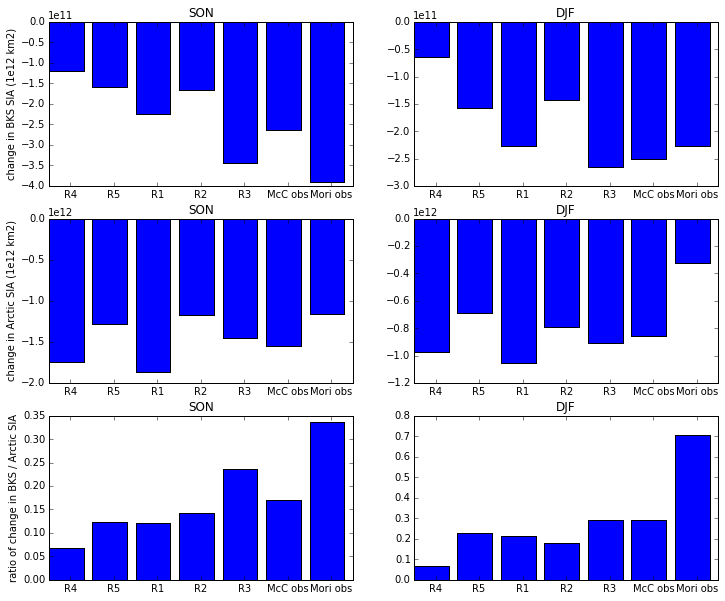

In [14]:
printtofile=False

print sicbkspson.keys()
print sicbkspson.values()

print sicbkscson.keys()
print sicbkscson.values()


print sondiff
print djfdiff

fig,axs = plt.subplots(3,2,figsize=(12,10))
ax=axs[0,0]
ax.bar(np.arange(0,len(sicbkspson.keys())), sondiff)
ax.set_xticks(np.arange(0,len(sicbkspson.keys()))+.5)
#ax.axhline(y=sonsimavg,xmin=0,xmax=4,color='g')
ax.set_xticklabels(sicbkspson.keys())
ax.set_title('SON')
if dosia:
    ax.set_ylabel('change in BKS SIA (1e12 km2)')
else:
    ax.set_ylabel('change in BKS SIC (%)')
ax=axs[0,1]
ax.bar(np.arange(0,len(sicbkspdjf.keys())), djfdiff)
ax.set_xticks(np.arange(0,len(sicbkspdjf.keys()))+.5)
#ax.axhline(y=djfsimavg,xmin=0,xmax=4,color='g')
ax.set_xticklabels(sicbkspdjf.keys())
ax.set_title('DJF')
#if printtofile:
#    fig.savefig('Mori_McCetal_BKS_' + ttl + 'change_BCcomparison.pdf')

    
#fig,axs = plt.subplots(1,2,figsize=(12,3))
ax=axs[1,0]
ax.bar(np.arange(0,len(sicarcpson.keys())), sonarcdiff)
ax.set_xticks(np.arange(0,len(sicarcpson.keys()))+.5)
ax.set_xticklabels(sicarcpson.keys())
ax.set_title('SON')
if dosia:
    ax.set_ylabel('change in Arctic SIA (1e12 km2)')
else:
    ax.set_ylabel('change in Arctic SIC (%)')

ax=axs[1,1]
ax.bar(np.arange(0,len(sicarcpdjf.keys())), djfarcdiff)
ax.set_xticks(np.arange(0,len(sicarcpdjf.keys()))+.5)
ax.set_xticklabels(sicarcpdjf.keys())
ax.set_title('DJF')
#if printtofile:
#    fig.savefig('Mori_McCetal_Arctic_' + ttl + 'change_BCcomparison.pdf')
    
    
#fig,axs = plt.subplots(1,2,figsize=(12,3))
ax=axs[2,0]
ax.bar(np.arange(0,len(sicarcpson.keys())), sondiff / sonarcdiff)
ax.set_xticks(np.arange(0,len(sicarcpson.keys()))+.5)
ax.set_xticklabels(sicarcpson.keys())
ax.set_title('SON')
ax.set_ylabel('ratio of change in BKS / Arctic ' + ttl )
ax=axs[2,1]
ax.bar(np.arange(0,len(sicarcpdjf.keys())), djfdiff / djfarcdiff)
ax.set_xticks(np.arange(0,len(sicarcpdjf.keys()))+.5)
ax.set_xticklabels(sicarcpdjf.keys())
ax.set_title('DJF')
if printtofile:
    fig.savefig('AGCMBC_Mori_McCobs_ArcticBKS_' + ttl + 'chgratio_bar_SONDJF.pdf')
    

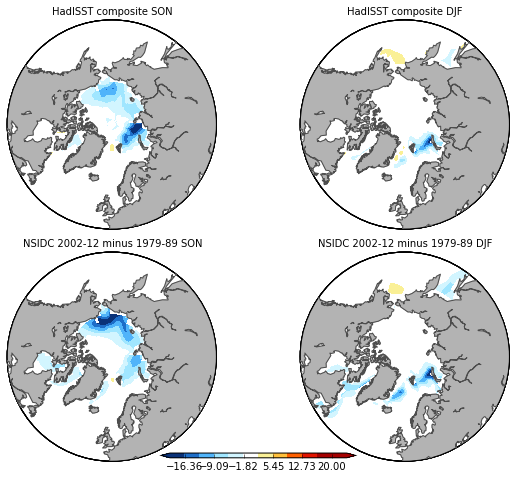

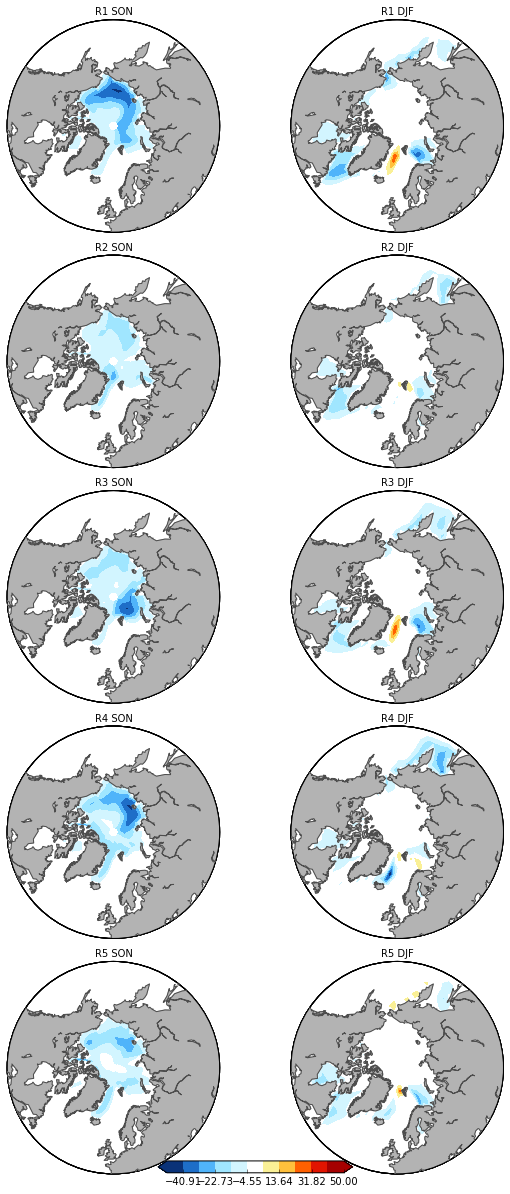

In [15]:


# Now plot AGCM boundary conditions compared to composite
printtofile=False


cmin=-50; cmax=50; 
pparams['cmin'] = cmin
pparams['cmax'] = cmax


fig,axs = plt.subplots(2,2,figsize=(9,3.3*2))
ax=axs[0,0]
cplt.kemmap(hsicmorisonlo-hsicmorisonhi,hlatsic,hlonsic,axis=ax,
            title='HadISST composite SON',suppcb=True,**pparams)
ax=axs[0,1]
cplt.kemmap(hsicmoridjflo-hsicmoridjfhi,hlatsic,hlonsic,axis=ax,
            title='HadISST composite DJF',suppcb=True,**pparams)

ax=axs[1,0]
cplt.kemmap(sicmcc2son-sicmcc1son,latsic,lonsic,axis=ax,
            title='NSIDC 2002-12 minus 1979-89 SON',suppcb=True,**pparams)
ax=axs[1,1]
cplt.kemmap(sicmcc2djf-sicmcc1djf,latsic,lonsic,axis=ax,
            title='NSIDC 2002-12 minus 1979-89 DJF',suppcb=True,**pparams)
fig.tight_layout()
cplt.add_colorbar(fig,pc,orientation='horizontal',pos=[.35,.03,.3,.01])
if printtofile:
    fig.savefig('Mori_McCetal_obs_SON_DJF_SICbcs.pdf')

    

fig,axs = plt.subplots(len(sims),2,figsize=(9,3.3*(len(sims))))

for eii,ekey in enumerate(sims):
    
    ax=axs[eii,0]
    bm,pc = cplt.kemmap(sicpson[ekey]-siccson[ekey],latsim,lonsim,
                        axis=ax,title=ekey+' '+'SON',suppcb=True,
                        **pparams)

    ax=axs[eii,1]
    bm,pc = cplt.kemmap(sicpdjf[ekey]-siccdjf[ekey],latsim,lonsim,
                        axis=ax,title=ekey+' '+'DJF',
                        suppcb=True,**pparams)
fig.tight_layout()
cplt.add_colorbar(fig,pc,orientation='horizontal',pos=[.35,.01,.3,.01])

if printtofile:
    fig.savefig('Mori_McCetal_AGCM_' + ekey[0] +'sims_SON_DJF_SICbcs.pdf')
        


In [4]:
# load data for Kug analysis
# LOAD DATA

con = reload(con)

sea='DJF'
# only need timeselk for the time series figure, which goes through 2014/15.
# Everything else through 2013/14 or 2012/13. :-/
timeselk = '1979-12-01,2014-02-31' # want to get just D, J, F starting in 1979-12 and ending in 2014-02
timeselk1 = '1979-12-01,1998-02-31'
timeselk2 = '1998-12-01,2014-02-31'

timedt={}; timeudt={}; timecaldt={}; datedt={}
fldkdt={}; fldk1dt={};fldk2dt={};
fldregkdt={}; fldregk1dt={}; fldregk2dt={};
fldkmdt={}; fldk1mdt={};fldk2mdt={};
fldregkmdt={}; fldregk1mdt={}; fldregk2mdt={};
latkdt={}; lonkdt={}; 
xxkdt={}; xxk1dt={}; xxk2dt={}
choosedjf=np.array(0)
for fkey in fnameskug.keys():
    print fkey
    fname = fnameskug[fkey]
    conv = convskug[fkey]
    print fname, fieldskug[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
    
    fldk = (cnc.getNCvar(fname,fieldskug[fkey],timesel=timeselk)*conv)#[:,:-1,:] (needed for diff resolution (121 x 241))
    timedt[fkey] = cnc.getNCvar(fname,'time',timesel=timeselk)
    timeudt[fkey] = cnc.get_NCtimeunits(fname)
    timecaldt[fkey] = cnc.get_NCtimecal(fname)
    #datedt[fkey] = cnc.get_NCdates(fname,timesel=timeselk)
    
    print 'timeselk ' + timeselk,str(fldk.shape)
    
    fldk1 = (cnc.getNCvar(fname,fieldskug[fkey],timesel=timeselk1)*conv)#[:,:-1,:]  
    fldk2 = (cnc.getNCvar(fname,fieldskug[fkey],timesel=timeselk2)*conv)#[:,:-1,:]  
    fldkm = selectmonths(fldk,start=0,incr=3,retavg=True)
    fldk = selectmonths(fldk,start=0,incr=3)
    
    print fldk.shape,fldkm.shape
    fldk1m = selectmonths(fldk1,start=0,incr=3,retavg=True)
    fldk1 = selectmonths(fldk1,start=0,incr=3)
    fldk2m = selectmonths(fldk2,start=0,incr=3,retavg=True)
    fldk2 = selectmonths(fldk2,start=0,incr=3)
    
    
    latkdt[fkey] = cnc.getNCvar(fname,'lat') #[:-1] (needed for diff resolution (121 x 241))
    lonkdt[fkey] = cnc.getNCvar(fname,'lon')

    fldkdt[fkey] = fldk
    fldk1dt[fkey] = fldk1
    fldk2dt[fkey] = fldk2
    fldkmdt[fkey] = fldkm
    fldk1mdt[fkey] = fldk1m
    fldk2mdt[fkey] = fldk2m

    regkdt={}; regk1dt={}; regk2dt={}
    regkmdt={}; regk1mdt={}; regk2mdt={}
    for regkey in regionskug.keys():
        print regkey
        regkdt[regkey] = cutl.calc_regmean(fldk,latkdt[fkey],lonkdt[fkey],
                                           regionskug[regkey],model=None,alsomask=alsomask)
        regk1dt[regkey] = cutl.calc_regmean(fldk1,latkdt[fkey],lonkdt[fkey],
                                            regionskug[regkey],model=None,alsomask=alsomask)
        regk2dt[regkey] = cutl.calc_regmean(fldk2,latkdt[fkey],lonkdt[fkey],
                                            regionskug[regkey],model=None,alsomask=alsomask)
        regkmdt[regkey] = cutl.calc_regmean(fldkm,latkdt[fkey],lonkdt[fkey],
                                            regionskug[regkey],model=None,alsomask=alsomask)
        regk1mdt[regkey] = cutl.calc_regmean(fldk1m,latkdt[fkey],lonkdt[fkey],
                                             regionskug[regkey],model=None,alsomask=alsomask)
        regk2mdt[regkey] = cutl.calc_regmean(fldk2m,latkdt[fkey],lonkdt[fkey],
                                             regionskug[regkey],model=None,alsomask=alsomask)
        

    xxkdt[fkey] = np.arange(0,len(regkmdt[regkey])) # length of last reg good for all reg in field
    xxk1dt[fkey] = np.arange(0,len(regk1mdt[regkey]))
    xxk2dt[fkey] = np.arange(0,len(regk2mdt[regkey]))
    fldregkdt[fkey] = regkdt
    fldregk1dt[fkey] = regk1dt
    fldregk2dt[fkey] = regk2dt
    fldregkmdt[fkey] = regkmdt
    fldregk1mdt[fkey] = regk1mdt
    fldregk2mdt[fkey] = regk2mdt


sic
/HOME/rkm/work/BCs/NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc SICN 100
timeselk 1979-12-01,2014-02-31 (409, 64, 129)
nyrs,remainder 34 1
nyrs 34
ret.shape (34, 64, 129)
nyrs 34, and 34
nyrs,remainder 34 1
nyrs 34
ret.shape (102, 64, 129)
nyrs 34, and 34
(102, 64, 129) (34, 64, 129)
nyrs,remainder 18 3
nyrs 19
ret.shape (19, 64, 129)
nyrs 19, and 19
nyrs,remainder 18 3
nyrs 19
ret.shape (57, 64, 129)
nyrs 19, and 19
nyrs,remainder 15 1
nyrs 15
ret.shape (15, 64, 129)
nyrs 15, and 15
nyrs,remainder 15 1
nyrs 15
ret.shape (45, 64, 129)
nyrs 15, and 15
lat: squeezing data upon read all
lon: squeezing data upon read all
NA
calc_regmean() removing extra lon. fld new shape: (102, 64, 128)
calc_regmean() removing extra lon. fld new shape: (57, 64, 128)
calc_regmean() removing extra lon. fld new shape: (45, 64, 128)
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
calc_regmean() removing extra lon. fld new shape: (19, 64, 128)
calc_regmean() removin

In [17]:
# Checking the time coordinate.
# Helped me fix a bug in selectmonths where last year was getting missed
# 2/23/2016
sattime = cnc.NCtime2date(timedt['sat'],timeudt['sat'],timecal=timecaldt['sat'])

sictime = cnc.NCtime2date(timedt['sic'],timeudt['sic'],timecal=timecaldt['sic'])

satdjf = selectmonths(sattime)

sicdjf = selectmonths(sictime)


print len(satdjf)

#print satdjf
print len(sicdjf)

nyrs,remainder 34 3
nyrs 35
selectmonths() on 1-D not supported @@@@
nyrs 35, and 35
nyrs,remainder 34 1
nyrs 34
selectmonths() on 1-D not supported @@@@
nyrs 34, and 34
105
102


timeselk 1979-12-01,2014-02-31
seasonal mean calcs ...
2013/14 REGR ART1 and EUR (obs) (detrended seasonal avg) -0.018265509752 0.917054840202
2012/13 REGR ART1 and EUR (obs) (detrended seasonal avg) -0.00995227910508 0.955451798013
REGR ART2 and NA (obs) (detrended seasonal avg) -0.662197622425 1.47195717138e-05
REGR BKSSIC and EUR (obs) (detrended seasonal avg) 0.300200565343 0.0845235752644
REGR BKSSIC (detrended seasonal) and EUR (obs) (raw seasonal avg) 0.290350017188 0.0957541860124
CORR ART1 and ART2 (obs) (raw winter avg 79/80-13/14))
0.120764286567 0.489540473809
CORR ART1 and ART2 (obs) (detrended winter avg 79/80-13/14))
0.000176597517254 0.999196673769
CORR ART1 and ART2 (obs) (raw winter avg 79/80-12/13))
(0.10610954305066249, 221.53064064548684, 0.15962414764209609, 0.38284856118739996)
CORR ART1 and ART2 (obs) (detrended winter avg 79/80-12/13))
(0.068181107112909964, 231.23185979732614, 0.1020634847360426, 0.57831855157093925)
(64, 129)
19
(64, 129)
16


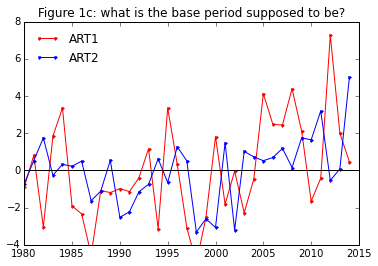

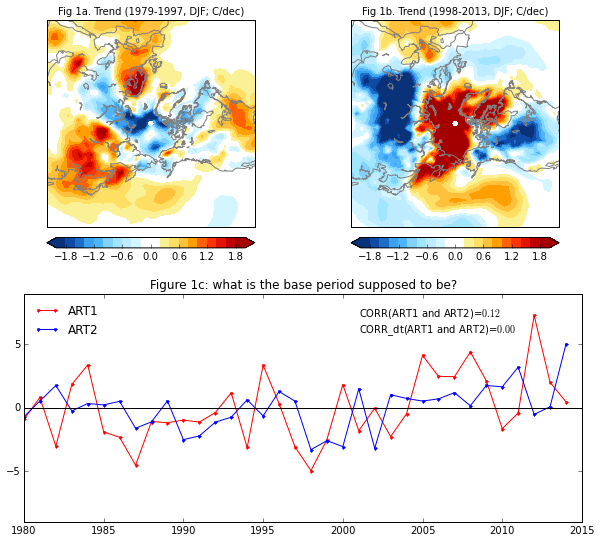

In [5]:
from matplotlib import gridspec

printtofile=False

print 'timeselk ' + timeselk
print 'seasonal mean calcs ...'
bkssatkm = fldregkmdt['sat']['BKS']
chucksatkm = fldregkmdt['sat']['CHUCK']
eursatkm = fldregkmdt['sat']['EUR']
nasatkm = fldregkmdt['sat']['NA']

bkssickm = fldregkmdt['sic']['BKS']


art1 = cutl.detrend(bkssatkm)
art2 = cutl.detrend(chucksatkm)
eursat = cutl.detrend(eursatkm) # seasonal avg
nasat = cutl.detrend(nasatkm) # seasonal avg

bkssickmdtr = cutl.detrend(bkssickm)

eurbkssat_mm,eurbkssat_bb,eurbkssat_r,eurbkssat_p=cutl.regress(art1,eursat)
print '2013/14 REGR ART1 and EUR (obs) (detrended seasonal avg) ' + str(eurbkssat_r),str(eurbkssat_p)
eurbkssat_mm,eurbkssat_bb,eurbkssat_r,eurbkssat_p=cutl.regress(art1[:-1],eursat[:-1])
print '2012/13 REGR ART1 and EUR (obs) (detrended seasonal avg) ' + str(eurbkssat_r),str(eurbkssat_p)

nachucksat_mm,nachucksat_bb,nachucksat_r,nachucksat_p=cutl.regress(art2,nasat)
print 'REGR ART2 and NA (obs) (detrended seasonal avg) ' + str(nachucksat_r),str(nachucksat_p)

eurbkssic_mm,eurbkssic_bb,eurbkssic_r,eurbkssic_p=cutl.regress(bkssickmdtr,eursat[:-1])
print 'REGR BKSSIC and EUR (obs) (detrended seasonal avg) ' + str(eurbkssic_r),str(eurbkssic_p)
eurbkssicb_mm,eurbkssicb_bb,eurbkssicb_r,eurbkssicb_p=cutl.regress(bkssickmdtr,eursatkm[:-1])
print 'REGR BKSSIC (detrended seasonal) and EUR (obs) (raw seasonal avg) ' + str(eurbkssicb_r),str(eurbkssicb_p)


cplt = reload(cplt)

styr = 1980

fig,axs = plt.subplots(1,1)
ax=axs
ax.plot(xxkdt['sat']+styr,bkssatkm-bkssatkm.mean(),color='r',marker='.')
ax.plot(xxkdt['sat']+styr,chucksatkm-chucksatkm.mean(),color='b',marker='.')
ax.axhline(y=0,color='k')
ax.set_ylim((-4,8))
ax.legend(('ART1','ART2'),frameon=False,loc='best')
ax.set_title('Figure 1c: what is the base period supposed to be?')

# Kug et al. numbers:
# CORR(ART1 and ART2) = 0.09
# CORRdt(ART1 and ART2) = -0.08

# My numbers: 0.21  # @@@@ check endpoints
#             0.05
_,_,bkschucksat_r,bkschucksat_p = cutl.regress(bkssatkm,chucksatkm)
print 'CORR ART1 and ART2 (obs) (raw winter avg 79/80-13/14))' 
print bkschucksat_r,bkschucksat_p
_,_,bkschucksat_rdtr,bkschucksat_pdtr = cutl.regress(cutl.detrend(bkssatkm),cutl.detrend(chucksatkm))
print 'CORR ART1 and ART2 (obs) (detrended winter avg 79/80-13/14))' 
print bkschucksat_rdtr,bkschucksat_pdtr

print 'CORR ART1 and ART2 (obs) (raw winter avg 79/80-12/13))' 
print cutl.regress(bkssatkm[:-3],chucksatkm[:-3])
print 'CORR ART1 and ART2 (obs) (detrended winter avg 79/80-12/13))' 
print cutl.regress(cutl.detrend(bkssatkm[:-3]),cutl.detrend(chucksatkm[:-3]))

bkssatspk1mm,bkssatspk1bb = cutl.trend(fldk1mdt['sat'])
print bkssatspk1mm.shape
print len(xxk1dt['sat'])


# Kug et al. Figure 1a-b is it trend/decade?  @@@
fig=plt.figure(figsize=(10,9))
gs1 = gridspec.GridSpec(2, 2)
#gs1.update(top=0.97,bottom=0.55,left=0.08,right=0.92,wspace=0.04)
ax=plt.subplot(gs1[0,0]) 


cplt.kemmap(bkssatspk1mm*10,latkdt['sat'],lonkdt['sat'],ptype='nhkug',latlim=30,round=False,axis=ax,
            cmin=-2,cmax=2,title='Fig 1a. Trend (1979-1997, DJF; C/dec)',lcol='0.5')

bkssatspk2mm,bkssatspk2bb = cutl.trend(fldk2mdt['sat'])
print bkssatspk2mm.shape
print len(xxk2dt['sat'])
ax=plt.subplot(gs1[0,1])
cplt.kemmap(bkssatspk2mm*10,latkdt['sat'],lonkdt['sat'],ptype='nhkug',latlim=30,round=False,axis=ax,
            cmin=-2,cmax=2,title='Fig 1b. Trend (1998-2013, DJF; C/dec)',lcol='0.5')

ax=plt.subplot(gs1[1,0:])
#ax=axs[1,:]
ax.plot(xxkdt['sat']+styr,bkssatkm-bkssatkm.mean(),color='r',marker='.')
ax.plot(xxkdt['sat']+styr,chucksatkm-chucksatkm.mean(),color='b',marker='.')
ax.axhline(y=0,color='k')
ax.set_ylim((-9,9))
ax.legend(('ART1','ART2'),frameon=False,loc='best')
ax.set_title('Figure 1c: what is the base period supposed to be?')
ax.annotate('CORR(ART1 and ART2)=$%.2f$'%(bkschucksat_r),xy=(.6,.9),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.annotate('CORR_dt(ART1 and ART2)=$%.2f$'%(bkschucksat_rdtr),xy=(.6,.83),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 

if printtofile:
    fig.savefig('myreg_kugetal_Fig1a-c.pdf')

monthly winter now...
REGIONS ARE bksmori and eurasiamori
bkssick.shape (102,)
eursatk.shape (105,)
nyr 34
remclimo.shape (3,)
remclimot.shape (102,)
nyr 34
remclimo.shape (3,)
remclimot.shape (102,)
nyr 34
remclimo.shape (3,)
remclimot.shape (102,)
nyr 34
remclimo.shape (3,)
remclimot.shape (102,)
nyr 35
remclimo.shape (3,)
remclimot.shape (105,)
nyr 35
remclimo.shape (3,)
remclimot.shape (105,)
nyr 35
remclimo.shape (3,)
remclimot.shape (105,)
nyr 35
remclimo.shape (3,)
remclimot.shape (105,)
(102,)
nyr 34
nyr 34
nyr 34
nyr 34
nyr 34
nyr 34
nyr 34
nyr 34
nyr 34
bkssickmon.shape (102,)
nyr 34
(102,) (102,) (102,)
----OBS: these data have the last 3 months removed (1 winter) to have it be thru 2012/13
REGR ART1 (detrended monthly) and EUR (climo removed) (obs) r,p -0.044472235285 0.657164256902
                                   slope:       -0.0310233742878
REGR ART1 and EUR (obs) (both detrended monthly) r,p 0.0189135698225 0.850343355638
                                   slope:    

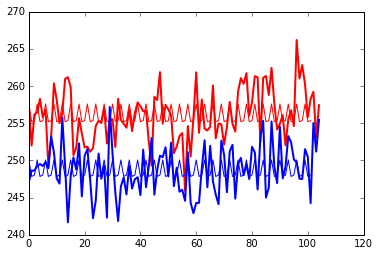

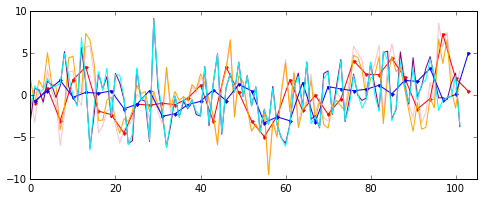

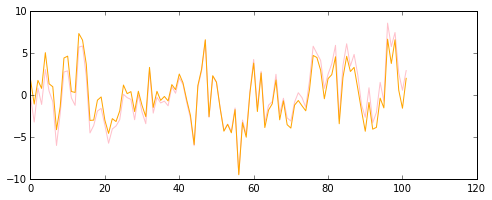

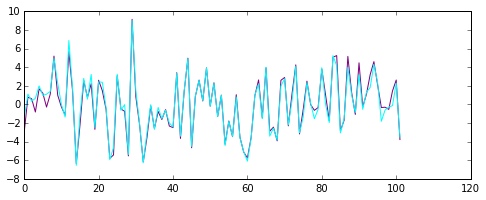

In [6]:
# create an art1 & 2 w/ the monthly dim still there:

print 'monthly winter now...'

print 'REGIONS ARE ' + regionskug['BKS'] + ' and ' + regionskug['EUR']

bkssatk = fldregkdt['sat']['BKS']
chucksatk = fldregkdt['sat']['CHUCK']
eursatk = fldregkdt['sat']['EUR']
nasatk = fldregkdt['sat']['NA']


bkssick = fldregkdt['sic']['BKS']
chucksick = fldregkdt['sic']['CHUCK']

print 'bkssick.shape ' + str(bkssick.shape)
print 'eursatk.shape ' + str(eursatk.shape)

# To compare to Figure 4c and 4d. Through 2012/2013
bkssatkrem,remclimob = rem_monmean(bkssatk[:-3],incr=3)
chucksatkrem,remclimoc = rem_monmean(chucksatk[:-3],incr=3)
eursatkrem,remclimoe = rem_monmean(eursatk[:-3],incr=3)
nasatkrem,remclimon = rem_monmean(nasatk[:-3],incr=3)

bkssatkremfull,_ = rem_monmean(bkssatk,incr=3)
chucksatkremfull,_ = rem_monmean(chucksatk,incr=3)
eursatkremfull,_ = rem_monmean(eursatk,incr=3)
nasatkremfull,_ = rem_monmean(nasatk,incr=3)

print bkssatkrem.shape

art1remmon = detrend_monthly(bkssatkrem,incr=3) 
art2remmon = detrend_monthly(chucksatkrem,incr=3) 
eursatremmon = detrend_monthly(eursatkrem,incr=3) 
nasatremmon = detrend_monthly(nasatkrem,incr=3) 

# Try w/o removing climo
art1mon = detrend_monthly(bkssatk[:-3],incr=3) 
art2mon = detrend_monthly(chucksatk[:-3],incr=3) 
eursatmon = detrend_monthly(eursatk[:-3],incr=3)
nasatmon = detrend_monthly(nasatk[:-3],incr=3) 

bkssickmon = detrend_monthly(bkssick,incr=3) 
print 'bkssickmon.shape ' + str(bkssickmon.shape)
chucksickmon = detrend_monthly(chucksick,incr=3) 

print art1mon.shape,art2mon.shape,eursatmon.shape

# Can't get these to match Fig 4c (obs) @@@@@@@
print '----OBS: these data have the last 3 months removed (1 winter) to have it be thru 2012/13'

eurbkssatnodt_mm,eurbkssat_bb,eurbkssatnodt_r,eurbkssatnodt_p=cutl.regress(art1mon,eursatkrem)
print 'REGR ART1 (detrended monthly) and EUR (climo removed) (obs) r,p ' + str(eurbkssatnodt_r),str(eurbkssatnodt_p)
print '                                   slope:       ' + str(eurbkssatnodt_mm)
eurbkssatsave_mm,eurbkssat_bb,eurbkssatsave_r,eurbkssatsave_p=cutl.regress(art1mon,eursatmon)
print 'REGR ART1 and EUR (obs) (both detrended monthly) r,p ' + str(eurbkssatsave_r),str(eurbkssatsave_p)
print '                                   slope:       ' + str(eurbkssatsave_mm)

eurbkssicnodt_mm,eurbkssic_bb,eurbkssicnodt_r,eurbkssicnodt_p=cutl.regress(bkssickmon,eursatkrem)
print 'REGR BKS SIC (detrended monthly) and EUR (climo removed) (obs) r,p ' + str(eurbkssic_r),str(eurbkssic_p)
print '                                   slope:       ' + str(eurbkssicnodt_mm)
eurbkssicsave_mm,eurbkssicb_bb,eurbkssicsave_r,eurbkssicsave_p=cutl.regress(bkssickmon,eursatmon)
print 'REGR BKS SIC and EUR (obs) (both detrended monthly) r,p ' + str(eurbkssicsave_r),str(eurbkssicsave_p)
print '                                   slope:       ' + str(eurbkssicsave_mm)


nachucksatnodtr_mm,nachucksat_bb,nachucksatnodtr_r,nachucksatnodtr_p=cutl.regress(art2mon,nasatkrem)
print 'REGR ART2 (detrended monthly) and NA (climo removed) (obs) ' + str(nachucksatnodtr_r),str(nachucksatnodtr_p)
print '                                   slope:       ' + str(nachucksatnodtr_mm)
# This is correct: matches Fig 4d (obs)
nachucksatsave_mm,nachucksat_bb,nachucksatsave_r,nachucksatsave_p=cutl.regress(art2mon,nasatmon)
print 'REGR ART2 and NA (obs) (both detrended monthly)' + str(nachucksatsave_r),str(nachucksatsave_p)
print '                                   slope:       ' + str(nachucksatsave_mm)

nachucksicnodtr_mm,nachucksic_bb,nachucksicnodtr_r,nachucksicnodtr_p=cutl.regress(chucksickmon,nasatkrem)
print 'REGR CHUCK SIC (detrended monthly) and NA (climo removed) (obs) ' + str(nachucksicnodtr_r),str(nachucksicnodtr_p)
print '                                   slope:       ' + str(nachucksicnodtr_mm)
nachucksicsave_mm,nachucksic_bb,nachucksicsave_r,nachucksicsave_p=cutl.regress(chucksickmon,nasatmon)
print 'REGR CHUCK SIC and NA (obs) (both detrended monthly)' + str(nachucksicsave_r),str(nachucksicsave_p)
print '                                   slope:       ' + str(nachucksicsave_mm)


print '----OBS. Try the full time period. ' + timeselk 

eurbkssat_mm,eurbkssat_bb,eurbkssat_r,eurbkssat_p=cutl.regress(detrend_monthly(bkssatk,incr=3),eursatkremfull)
print 'REGR ART1 (detrended monthly) and EUR (climo removed) (obs) ' + str(eurbkssat_r),str(eurbkssat_p)
eurbkssat_mm,eurbkssat_bb,eurbkssat_r,eurbkssat_p=cutl.regress(detrend_monthly(bkssatk,incr=3),detrend_monthly(eursatk,incr=3))
print 'REGR ART1 and EUR (obs) (both detrended monthly)' + str(eurbkssat_r),str(eurbkssat_p)


nachucksat_mm,nachucksat_bb,nachucksat_r,nachucksat_p=cutl.regress(detrend_monthly(chucksatk,incr=3),nasatkremfull)
print 'REGR ART2 (detrended monthly) and NA (climo removed) (obs) ' + str(nachucksat_r)
# This is correct: matches Fig 4d (obs)
nachucksat_mm,nachucksat_bb,nachucksat_r,nachucksat_p=cutl.regress(detrend_monthly(chucksatk,incr=3),detrend_monthly(nasatk,incr=3))
print 'REGR ART2 and NA (obs) (both detrended monthly)' + str(nachucksat_r)


plt.figure()
plt.plot(bkssatk,'r',linewidth=2)
plt.plot(remclimob,'r')
plt.plot(chucksatk,'b',linewidth=2)
plt.plot(remclimoc,'b')

fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.plot(bkssatkrem,'pink')
plt.plot(range(1,len(bkssatk),3),bkssatkm-bkssatkm.mean(),'r',marker='.')
plt.plot(art1remmon,'orange')
plt.plot(chucksatkrem,'purple')
plt.plot(range(1,len(chucksatk),3),chucksatkm-chucksatkm.mean(),'b',marker='.')
plt.plot(art2remmon,'cyan')
plt.xlim((0,105))

fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.plot(bkssatkrem,'pink')
plt.plot(art1remmon,'orange')

fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.plot(chucksatkrem,'purple')
plt.plot(art2remmon,'cyan')


In [20]:
import loadLE as le

addlespatial=True

# detrend the LE data or not? Set to TRUE for correct Kug analysis.
#    this will detrend the indices (and SIC) and remove climo from midlat SAT and spatial SAT
detrendle=True

casename='historical'
timeselk_fig4 = '1979-12-01,2013-02-31'
print 'timeselk_fig4 ' + timeselk_fig4
print '   for monthly calcs'

# load in large ensemble data to calc ART1 to EUR correlations
#    steps: select desired months (D,J,F)
#           detrend each month separately
#           correlate detrended monthly timeseries for e/ ens member

if addlespatial: # this causes memory errors at the detrend() step

    #  SPATIAL FIELD:
    fdictksat = {'field': 'tas', 'ncfield': 'tas', 'comp': 'Amon'}
    conv=convskug['sat']
    ledatsatk = le.load_LEdata(fdictksat,casename,timesel=timeselk_fig4, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=True,
                       verb=False, subens=('historical-r2',)) # @@@ try getting less
    print ledatsatk.shape

    # put time in first dim & select months:
    ledatsatk = np.transpose(ledatsatk,(1,0,2))
    lesatk = selectmonths(ledatsatk,start=0,incr=3) # 'm' is the seasonal mean
    print lesatk.shape
    # detrend the full sat field:
    if detrendle:
        dtstr = 'detrendrem'
        #print 'DETRENDING LE spatial SAT'
        print 'Do not actually detrend spatial SAT. REMOVE CLIMO.'
        #lesatspkmon = detrend_monthly(lesatk,incr=3) # for 'detrend'
        lesatspkmon,_ = rem_monmean(lesatk,incr=3) # for 'detrendrem'
    else:
        dtstr = 'rawrem'
        print 'DO NOT DETREND LE spatial SAT. REMOVE CLIMO INSTEAD @@'
        print 'It is recommended to use detrended indices, and climo removed midlat SAT and spatial SAT for Kug analysis.'

        #lesatspkmon = lesatk # @@ try not detrending
        lesatspkmon,_ = rem_monmean(lesatk,incr=3)

timeselk_fig4 1979-12-01,2013-02-31
   for monthly calcs
(10, 399, 8192)
(10, 399, 8192)
(10, 399, 8192)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 10, 8192)
nyrs 34, and 34
(102, 10, 8192)
Do not actually detrend spatial SAT. REMOVE CLIMO.
nyr 34
remclimo.shape (3, 10, 8192)
remclimot.shape (102, 10, 8192)


In [23]:
timeselsea = timeselk_fig4 #timeselk2 # this is the timesel for selecting DJF seasonal avg, for LE trends

print 'Getting monthly data for time period: ' + timeselk_fig4
print 'Getting seasonal avg data for time period: ' + timeselsea

#  LE: THESE ARE ALL REGIONAL AVERAGES
fdicteurksat = {'field': 'tas'+regionskug['EUR'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=convskug['sat']
ledateursatk = le.load_LEdata(fdicteurksat,casename,timesel=timeselk_fig4, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
print ledateursatk.shape
leeursatk = selectmonths(ledateursatk.T,start=0,incr=3) 
#leeursatkm = selectmonths(ledateursatk.T,start=0,incr=3,retavg=True) # 'm' is the seasonal mean
print leeursatk.shape # time (selected months) x ensemble #,leeursatkm.shape

#  Now load the trend for DJF avg (for calcs across ensemble dimension)
leeursatkavg,leeursatktr,leeursatktrbb = load_field(fdicteurksat, casename, timeselsea,verb=False,
                                ftype='fullts', orig=None,conv=conv,local=True,calc='trend',seas=sea)
print 'DJF avg, trend shape ' + str(leeursatktr.shape) # shape is [ensemble]


fdictbksksat = {'field': 'tas'+regionskug['BKS'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=convskug['sat']
ledatbkssatk = le.load_LEdata(fdictbksksat,casename,timesel=timeselk_fig4, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
print ledatbkssatk.shape
lebkssatk = selectmonths(ledatbkssatk.T,start=0,incr=3) 
#lebkssatkm = selectmonths(ledatbkssatk.T,start=0,incr=3,retavg=True) # 'm' is the seasonal mean
print lebkssatk.shape#,lebkssatkm.shape
#  Now load the trend for DJF avg (for calcs across ensemble dimension)
lebkssatkavg,lebkssatktr,lebkssatktrbb = load_field(fdictbksksat, casename, timeselsea,verb=False,
                                ftype='fullts', orig=None,conv=conv,local=True,calc='trend',seas=sea)
print 'DJF avg, trend shape ' + str(lebkssatktr.shape)


fdictchuckksat = {'field': 'tas'+regionskug['CHUCK'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=convskug['sat']
ledatchucksatk = le.load_LEdata(fdictchuckksat,casename,timesel=timeselk_fig4, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
print ledatchucksatk.shape
lechucksatk = selectmonths(ledatchucksatk.T,start=0,incr=3)
#lechucksatkm = selectmonths(ledatchucksatk.T,start=0,incr=3,retavg=True) # 'm' is the seasonal mean
print lechucksatk.shape#,lechucksatkm.shape
#  Now load the trend for DJF avg (for calcs across ensemble dimension)
lechucksatkavg,lechucksatktr,lechucksatktrbb = load_field(fdictchuckksat, casename, timeselsea,verb=False,
                                ftype='fullts', orig=None,conv=conv,local=True,calc='trend',seas=sea)
print 'DJF avg, trend shape ' + str(lechucksatktr.shape)



fdictnaksat = {'field': 'tas'+regionskug['NA'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=convskug['sat']
ledatnasatk = le.load_LEdata(fdictnaksat,casename,timesel=timeselk_fig4, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
print ledatnasatk.shape
lenasatk = selectmonths(ledatnasatk.T,start=0,incr=3) 
#lenasatkm = selectmonths(ledatnasatk.T,start=0,incr=3,retavg=True) # 'm' is the seasonal mean
print lenasatk.shape#,lenasatkm.shape
#  Now load the trend for DJF avg (for calcs across ensemble dimension)
lenasatkavg,lenasatktr,lenasatktrbb = load_field(fdictnaksat, casename, timeselsea,verb=False,
                                ftype='fullts', orig=None,conv=conv,local=True,calc='trend',seas=sea)
print 'DJF avg, trend shape ' + str(lenasatktr.shape)


# ############ compare with SEAICE
fdictbksksic = {'field': 'sic'+regionskug['BKS'], 'ncfield': 'sic', 'comp': 'OImon'}
conv=1
ledatbkssick = le.load_LEdata(fdictbksksic,casename,timesel=timeselk_fig4, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
print ledatbkssick.shape
lebkssick = selectmonths(ledatbkssick.T,start=0,incr=3) 
print lebkssick.shape
#  Now load the trend for DJF avg (for calcs across ensemble dimension)
lebkssickavg,lebkssicktr,lebkssicktrbb = load_field(fdictbksksic, casename, timeselsea,verb=False,
                                ftype='fullts', orig=None,conv=conv,local=True,calc='trend',seas=sea)
print 'DJF avg, trend shape ' + str(lebkssicktr.shape)


fdictchuckksic = {'field': 'sic'+regionskug['CHUCK'], 'ncfield': 'sic', 'comp': 'OImon'}
conv=1
ledatchucksick = le.load_LEdata(fdictchuckksic,casename,timesel=timeselk_fig4, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
print ledatchucksick.shape
lechucksick = selectmonths(ledatchucksick.T,start=0,incr=3)
print lechucksick.shape
#  Now load the trend for DJF avg (for calcs across ensemble dimension)
lechucksickavg,lechucksicktr,lechucksicktrbb = load_field(fdictchuckksic, casename, timeselsea,verb=False,
                                ftype='fullts', orig=None,conv=conv,local=True,calc='trend',seas=sea)
print 'DJF avg, trend shape ' + str(lechucksicktr.shape)




# these calc'ing correlations in time
cutl=reload(cutl)

if detrendle:
    print 'DETRENDING LE ART1,ART2,BKSSIC,CHUCKSIC and removing climo from EURSAT,NASAT @@'
    leart1mon = detrend_monthly(lebkssatk,incr=3) 
    leart2mon = detrend_monthly(lechucksatk,incr=3) 
    
    #leeursatmon = detrend_monthly(leeursatk,incr=3) # I flip flop b/w detrend and remclimo. for 'detrend'
    #lenasatmon = detrend_monthly(lenasatk,incr=3)  # for 'detrend'
    
    leeursatmon,_ = rem_monmean(leeursatk,incr=3) # for 'detrendrem'
    lenasatmon,_ =rem_monmean(lenasatk,incr=3) # for 'detrendrem'
    
    
    # compare to analyzing SIC directly (instead of SAT)
    lebkssicmon = detrend_monthly(lebkssick,incr=3) 
    lechucksicmon = detrend_monthly(lechucksick,incr=3) 
else:
    ##print 'DO NOT DETREND LE ART1,ART2,EURSAT,NASAT. REMOVE CLIMO@@'
    # @@@@ remove climo??
    
    #leart1mon = lebkssatk # need to copy??
    #leart2mon = lechucksatk 
    #leeursatmon = leeursatk
    #lenasatmon =lenasatk

    # compare to analyzing SIC directly (instead of SAT)
    #lebkssicmon = lebkssick
    #lechucksicmon = lechucksick
    print 'DO NOT DETREND LE ART1,ART2,EURSAT,NASAT. REMOVE CLIMO INSTEAD @@'
    print 'NOT recommended for Kug Fig 4. Use detrended indices, and climo removed midlat SAT and spatial SAT'
    leart1mon,_ = rem_monmean(lebkssatk,incr=3)
    leart2mon,_ = rem_monmean(lechucksatk ,incr=3)
    leeursatmon,_ = rem_monmean(leeursatk,incr=3)
    lenasatmon,_ =rem_monmean(lenasatk,incr=3)
    
    lebkssicmon,_ = rem_monmean(lebkssick,incr=3)
    lechucksicmon,_ = rem_monmean(lechucksick,incr=3)
    
    
print leart1mon.shape,leeursatmon.shape



leeurbkssat_mm,leeurbkssat_bb,leeurbkssat_r,leeurbkssat_p=cutl.regress(leart1mon,leeursatmon)
print leeurbkssat_r.shape

lenachucksat_mm,lenachucksat_bb,lenachucksat_r,lenachucksat_p=cutl.regress(leart2mon,lenasatmon)
print lenachucksat_r.shape




leeurbkssic_mm,leeurbkssic_bb,leeurbkssic_r,leeurbkssic_p=cutl.regress(lebkssicmon,leeursatmon)
lenachucksic_mm,lenachucksic_bb,lenachucksic_r,lenachucksic_p=cutl.regress(lechucksicmon,lenasatmon)


Getting monthly data for time period: 1979-12-01,2013-02-31
Getting seasonal avg data for time period: 1979-12-01,2013-02-31
(50, 399)
(50, 399)
(50, 399)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 50)
nyrs 34, and 34
(102, 50)
(50, 399)
(50, 399)
DJF avg, trend shape (50,)
(50, 399)
(50, 399)
(50, 399)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 50)
nyrs 34, and 34
(102, 50)
(50, 399)
(50, 399)
DJF avg, trend shape (50,)
(50, 399)
(50, 399)
(50, 399)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 50)
nyrs 34, and 34
(102, 50)
(50, 399)
(50, 399)
DJF avg, trend shape (50,)
(50, 399)
(50, 399)
(50, 399)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 50)
nyrs 34, and 34
(102, 50)
(50, 399)
(50, 399)
DJF avg, trend shape (50,)
(50, 399)
(50, 399)
(50, 399)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 50)
nyrs 34, and 34
(102, 50)
(50, 399)
(50, 399)
DJF avg, trend shape (50,)
(50, 399)
(50, 399)
(50, 399)
nyrs,remainder 33 3
nyrs 34
ret.shape (102, 50)
nyrs 34, and 34
(102, 50)
(50, 399)
(50, 3

detrendle True dtstr detrendrem
eurbkssatnodt_r -0.044472235285
eurbkssatsave_r 0.0189135698225
eurbkssatnodt_p 0.657164256902
eurbkssatsave_p 0.850343355638
nachucksatnodtr_r -0.555836798509
nachucksatsave_r -0.464097962896
eurbkssicnodt_r 0.242864187678
eurbkssicsave_r 0.221489260074
eurbkssicnodt_p 0.0139122670487
eurbkssicsave_p 0.0252715015937
nachucksicnodtr_r 0.103138463378
nachucksicsave_r 0.0367796002514


'\n   save means: #ART1 and EUR (obs) (both detrended monthly)\n   nodt(r) means: #ART1 (detrended monthly) and EUR (climo removed)\ndetrendle True dtstr detrend\neurbkssatnodt_r -0.466382229696\neurbkssatsave_r -0.321127090889\neurbkssatnodt_p 7.79486842776e-07\nnachucksatnodtr_r -0.555836798509\nnachucksatsave_r -0.464097962896\neurbkssicnodt_r 0.356503776342\neurbkssicsave_r 0.293598107647\neurbkssicnodt_p 0.000235302990512\nnachucksicnodtr_r 0.114930513995\nnachucksicsave_r 0.0418998740814\n'

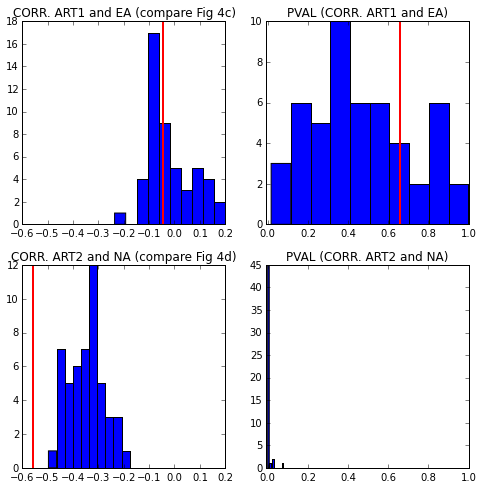

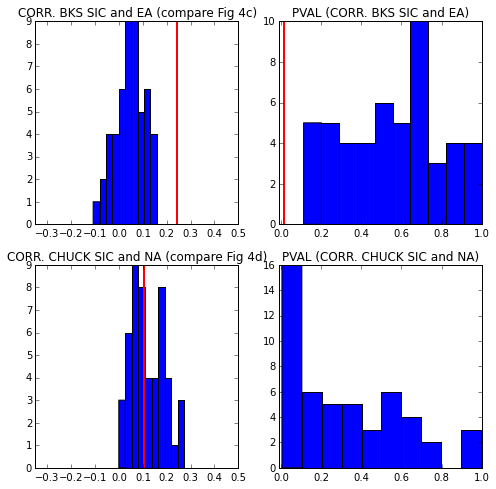

In [24]:
import numpy.ma as ma

print 'detrendle ' + str(detrendle) + ' dtstr ' + dtstr

printtofile=False

# ============ CORRELATION COEFS =============
fig,axs=plt.subplots(2,2,figsize=(8,8))
ax=axs[0,0]
ax.hist(leeurbkssat_r)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssatnodt_r ' + str(eurbkssatnodt_r)# ART1 (detrended monthly) and EUR (climo removed)
ax.axvline(x=eurbkssatnodt_r,color='r',linewidth=2)
print 'eurbkssatsave_r ' + str(eurbkssatsave_r) #ART1 and EUR (obs) (both detrended monthly)
#ax.axvline(x=eurbkssatsave_r,color='r',linewidth=2)
ax.set_xlim((-.6,0.2))
ax.set_title('CORR. ART1 and EA (compare Fig 4c)')

ax=axs[0,1]
ax.hist(leeurbkssat_p)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssatnodt_p ' + str(eurbkssatnodt_p)
print 'eurbkssatsave_p ' + str(eurbkssatsave_p)
ax.axvline(x=eurbkssatnodt_p,color='r',linewidth=2)
#ax.axvline(x=eurbkssatsave_p,color='r',linewidth=2)
ax.set_xlim((-.01,1))
ax.set_title('PVAL (CORR. ART1 and EA)')

ax=axs[1,0]
ax.hist(lenachucksat_r)
print 'nachucksatnodtr_r ' + str(nachucksatnodtr_r)
ax.axvline(x=nachucksatnodtr_r,color='r',linewidth=2)
print 'nachucksatsave_r ' + str(nachucksatsave_r)
#ax.axvline(x=nachucksatsave_r,color='r',linewidth=2)

ax.set_xlim((-.6,0.2))
ax.set_title('CORR. ART2 and NA (compare Fig 4d)')
ax=axs[1,1]
ax.hist(lenachucksat_p)
ax.set_xlim((-.01,1))
ax.set_title('PVAL (CORR. ART2 and NA)')
if printtofile:
    fig.savefig('myreg_LE_ARTregressonEURNASAT' + dtstr + '_rvals_pvals_hist.pdf')


# @@@@@@@@@@@@ Repeat this w/ BKS and CHUCK sic

fig,axs=plt.subplots(2,2,figsize=(8,8))
ax=axs[0,0]
ax.hist(leeurbkssic_r)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssicnodt_r ' + str(eurbkssicnodt_r)
ax.axvline(x=eurbkssicnodt_r,color='r',linewidth=2)
print 'eurbkssicsave_r ' + str(eurbkssicsave_r)
#ax.axvline(x=eurbkssicsave_r,color='r',linewidth=2)
ax.set_xlim((-.35,.5))
ax.set_title('CORR. BKS SIC and EA (compare Fig 4c)')

ax=axs[0,1]
ax.hist(leeurbkssic_p)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssicnodt_p ' + str(eurbkssicnodt_p)
print 'eurbkssicsave_p ' + str(eurbkssicsave_p)
ax.axvline(x=eurbkssicnodt_p,color='r',linewidth=2)
#ax.axvline(x=eurbkssicsave_p,color='r',linewidth=2)
ax.set_xlim((-.01,1))
ax.set_title('PVAL (CORR. BKS SIC and EA)')

ax=axs[1,0]
ax.hist(lenachucksic_r)
print 'nachucksicnodtr_r ' + str(nachucksicnodtr_r)
ax.axvline(x=nachucksicnodtr_r,color='r',linewidth=2)
print 'nachucksicsave_r ' + str(nachucksicsave_r)
#ax.axvline(x=nachucksicsave_r,color='r',linewidth=2)
ax.set_xlim((-.35,.5))
ax.set_title('CORR. CHUCK SIC and NA (compare Fig 4d)')

ax=axs[1,1]
ax.hist(lenachucksic_p)
ax.set_xlim((-0.01,1))
ax.set_title('PVAL (CORR. CHUCK SIC and NA)')
if printtofile:
    fig.savefig('myreg_LE_SICregressonEURNASAT' + dtstr + '_rvals_pvals_hist.pdf')

    
"""
   save means: #ART1 and EUR (obs) (both detrended monthly)
   nodt(r) means: #ART1 (detrended monthly) and EUR (climo removed)
detrendle True dtstr detrend
eurbkssatnodt_r -0.466382229696
eurbkssatsave_r -0.321127090889
eurbkssatnodt_p 7.79486842776e-07
nachucksatnodtr_r -0.555836798509
nachucksatsave_r -0.464097962896
eurbkssicnodt_r 0.356503776342
eurbkssicsave_r 0.293598107647
eurbkssicnodt_p 0.000235302990512
nachucksicnodtr_r 0.114930513995
nachucksicsave_r 0.0418998740814
"""

---------------------------------------
eurbkssatnodt_mm -0.0310233742878
eurbkssatsave_mm 0.014981358995
eurbkssatnodt_p 0.657164256902
eurbkssatsave_p 0.850343355638
nachucksatnodtr_mm -0.435122805517
nachucksatsave_mm -0.388840368425
eurbkssicnodt_mm 0.0826391056435
eurbkssicsave_mm 0.0855760884504
eurbkssicnodt_p 0.0139122670487
eurbkssicsave_p 0.0252715015937
nachucksicnodtr_mm 0.164269289021
nachucksicsave_mm 0.0626960035833


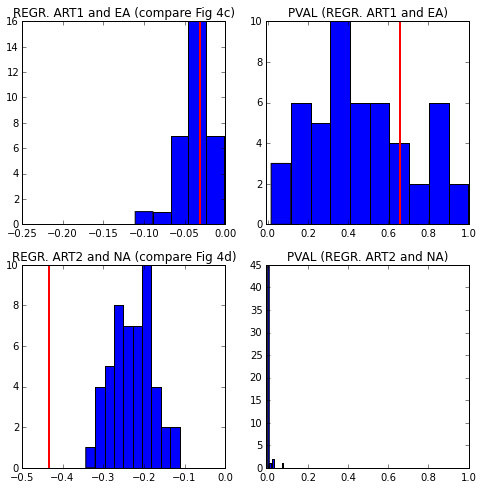

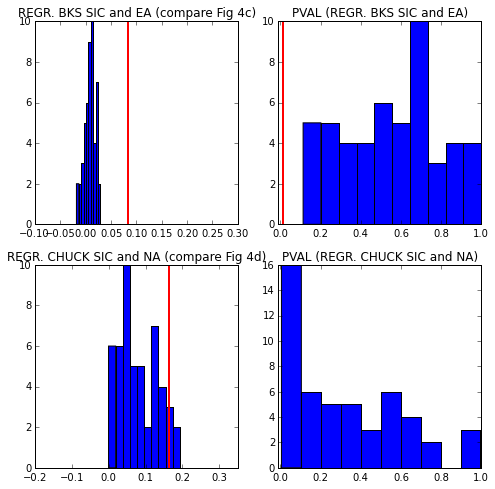

In [25]:
# ======================================================================
# @@@@@@ Actually the paper shows REGRESSION COEFFS, not CORRELATION COEFFS
#    so should be plotting mm (slope)

printtofile=False

print '---------------------------------------'
fig,axs=plt.subplots(2,2,figsize=(8,8))
ax=axs[0,0]
ax.hist(leeurbkssat_mm)

# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssatnodt_mm ' + str(eurbkssatnodt_mm)# ART1 (detrended monthly) and EUR (climo removed)
ax.axvline(x=eurbkssatnodt_mm,color='r',linewidth=2)
print 'eurbkssatsave_mm ' + str(eurbkssatsave_mm) #ART1 and EUR (obs) (both detrended monthly)
#ax.axvline(x=eurbkssatsave_mm,color='r',linewidth=2)
ax.set_xlim((-.25,0))
ax.set_title('REGR. ART1 and EA (compare Fig 4c)')

ax=axs[0,1]
ax.hist(leeurbkssat_p)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssatnodt_p ' + str(eurbkssatnodt_p)
print 'eurbkssatsave_p ' + str(eurbkssatsave_p)
ax.axvline(x=eurbkssatnodt_p,color='r',linewidth=2)
#ax.axvline(x=eurbkssatsave_p,color='r',linewidth=2)
ax.set_xlim((-.01,1))
ax.set_title('PVAL (REGR. ART1 and EA)')

ax=axs[1,0]
ax.hist(lenachucksat_mm)
print 'nachucksatnodtr_mm ' + str(nachucksatnodtr_mm)
ax.axvline(x=nachucksatnodtr_mm,color='r',linewidth=2)
print 'nachucksatsave_mm ' + str(nachucksatsave_mm)
#ax.axvline(x=nachucksatsave_mm,color='r',linewidth=2)
ax.set_xlim((-.5,0))
ax.set_title('REGR. ART2 and NA (compare Fig 4d)')

ax=axs[1,1]
ax.hist(lenachucksat_p)
ax.set_xlim((-.01,1))
ax.set_title('PVAL (REGR. ART2 and NA)')
if printtofile:
    fig.savefig('myreg_LE_mmARTregressonEURNASAT' + dtstr + '_rvals_pvals_hist.pdf')


# @@@@@@@@@@@@ Repeat this w/ BKS and CHUCK sic

fig,axs=plt.subplots(2,2,figsize=(8,8))
ax=axs[0,0]
ax.hist(leeurbkssic_mm)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssicnodt_mm ' + str(eurbkssicnodt_mm)
ax.axvline(x=eurbkssicnodt_mm,color='r',linewidth=2)
print 'eurbkssicsave_mm ' + str(eurbkssicsave_mm)
#ax.axvline(x=eurbkssicsave_mm,color='r',linewidth=2)
ax.set_xlim((-.1,.3))
ax.set_title('REGR. BKS SIC and EA (compare Fig 4c)')

ax=axs[0,1]
ax.hist(leeurbkssic_p)
# actually the correct calc is: detrend monthly indices, w/ climo removed from midlat temp
print 'eurbkssicnodt_p ' + str(eurbkssicnodt_p)
print 'eurbkssicsave_p ' + str(eurbkssicsave_p)
ax.axvline(x=eurbkssicnodt_p,color='r',linewidth=2)
#ax.axvline(x=eurbkssicsave_p,color='r',linewidth=2)
ax.set_xlim((-.01,1))
ax.set_title('PVAL (REGR. BKS SIC and EA)')

ax=axs[1,0]
ax.hist(lenachucksic_mm)
print 'nachucksicnodtr_mm ' + str(nachucksicnodtr_mm)
ax.axvline(x=nachucksicnodtr_mm,color='r',linewidth=2)
print 'nachucksicsave_mm ' + str(nachucksicsave_mm)
#ax.axvline(x=nachucksicsave_mm,color='r',linewidth=2)
ax.set_xlim((-.2,.35))
ax.set_title('REGR. CHUCK SIC and NA (compare Fig 4d)')

ax=axs[1,1]
ax.hist(lenachucksic_p)
ax.set_xlim((-0.01,1))
ax.set_title('PVAL (REGR. CHUCK SIC and NA)')
if printtofile:
    fig.savefig('myreg_LE_mmSICregressonEURNASAT' + dtstr + '_rvals_pvals_hist.pdf')

avg LE ART1 EA SAT reg coef: -0.00872423442323


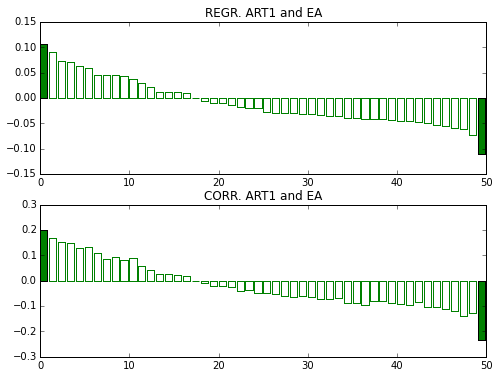

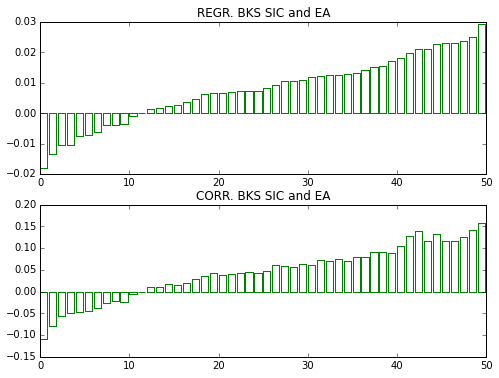

In [27]:
# ============== Plot a ranked bar plot of reg coefs a la Kug Fig 4c

printtofile=False

leeurbkssat_mm_m = ma.masked_where(leeurbkssat_p>0.05,leeurbkssat_mm)
leeurbkssat_r_m = ma.masked_where(leeurbkssat_p>0.05,leeurbkssat_r)

fig,axs=plt.subplots(2,1,figsize=(8,6))
ax=axs[0]
ax.bar(np.arange(0,len(leeurbkssat_mm)),ma.sort(leeurbkssat_mm)[::-1],
       color='none',edgecolor='g')
ax.bar(np.arange(0,len(leeurbkssat_mm_m)),leeurbkssat_mm_m[ma.argsort(leeurbkssat_mm)[::-1]],
       color='g')
print 'avg LE ART1 EA SAT reg coef: ' + str(leeurbkssat_mm.mean())
ax.set_title('REGR. ART1 and EA')
ax=axs[1]
ax.bar(np.arange(0,len(leeurbkssat_r)),leeurbkssat_r[ma.argsort(leeurbkssat_mm)[::-1]],
       color='none',edgecolor='g')
ax.bar(np.arange(0,len(leeurbkssat_r_m)),leeurbkssat_r_m[ma.argsort(leeurbkssat_mm)[::-1]],
       color='g')
ax.set_title('CORR. ART1 and EA')
if printtofile:
    fig.savefig('myreg_LE_ART1regressonEURSAT' + dtstr + '_sortedmm_rvalssig_bar.pdf')
    fig.savefig('myreg_LE_ART1regressonEURSAT' + dtstr + '_sortedmm_rvalssig_bar.png',dpi=300)


leeurbkssic_mm_m = ma.masked_where(leeurbkssic_p>0.05,leeurbkssic_mm)
leeurbkssic_r_m = ma.masked_where(leeurbkssic_p>0.05,leeurbkssic_r)

fig,axs=plt.subplots(2,1,figsize=(8,6))
ax=axs[0]
ax.bar(np.arange(0,len(leeurbkssic_mm)),ma.sort(leeurbkssic_mm),
       color='none',edgecolor='g')
ax.bar(np.arange(0,len(leeurbkssic_mm_m)),leeurbkssic_mm_m[ma.argsort(leeurbkssic_mm)],
       color='g')
ax.set_title('REGR. BKS SIC and EA')
ax=axs[1]
ax.bar(np.arange(0,len(leeurbkssic_r)),leeurbkssic_r[ma.argsort(leeurbkssic_mm)],
       color='none',edgecolor='g')
ax.bar(np.arange(0,len(leeurbkssic_r_m)),leeurbkssic_r_m[ma.argsort(leeurbkssic_mm)],
       color='g')
ax.set_title('CORR. BKS SIC and EA')
if printtofile:
    fig.savefig('myreg_LE_BKSSICregressonEURSAT' + dtstr + '_sortedmm_rvalssig_bar.pdf')
    fig.savefig('myreg_LE_BKSSICregressonEURSAT' + dtstr + '_sortedmm_rvalssig_bar.png',dpi=300)


timeselsea 1979-12-01,2013-02-31
(34,)
obs trends: bkssat,eursat: 0.104940361434 -0.0429783680766
obs trends: chucksat,nasat: 0.0347917015819 0.024561980519
obs trends: bkssic: -0.566433672284
(34,) (34,)
obsmm1,obsbb1,obs_r1,obs_p1 = cutl.regress(bkssatkm,eursatkm) # mm, bb, r-val, p-val
-0.0645673169265 275.190511147 -0.105725068789 0.551782882647
obsmm1si,obsbb1si,obs_r1si,obs_p1si = cutl.regress(bkssickm,eursatkm) # mm, bb, r-val, p-val
0.0822490364028 253.229704742 0.385670517701 0.0242806987455


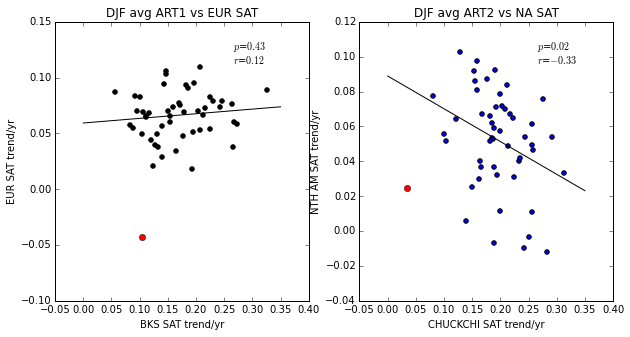

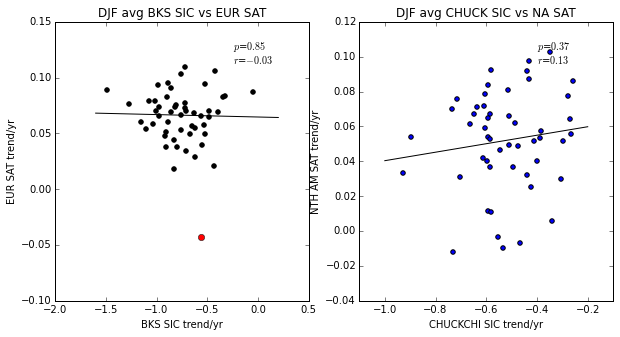

In [28]:
# Here we test if the long term changes in Arctic SIC/SAT correlate w/ long term midlat SAT changes
printtofile=False


# ==== obs data to compare to LE trends ======
#   THESE ARE SEASONAL MEANS
if timeselsea == timeselk2:
    bkssatkm = fldregk2mdt['sat']['BKS']
    chucksatkm = fldregk2mdt['sat']['CHUCK']
    eursatkm = fldregk2mdt['sat']['EUR']
    nasatkm = fldregk2mdt['sat']['NA']
    bkssickm = fldregk2mdt['sic']['BKS']
elif timeselsea == timeselk1:
    bkssatkm = fldregk1mdt['sat']['BKS']
    chucksatkm = fldregk1mdt['sat']['CHUCK']
    eursatkm = fldregk1mdt['sat']['EUR']
    nasatkm = fldregk1mdt['sat']['NA']
    bkssickm = fldregk1mdt['sic']['BKS']
elif timeselsea == timeselk:
    bkssatkm = fldregkmdt['sat']['BKS']
    chucksatkm = fldregkmdt['sat']['CHUCK']
    eursatkm = fldregkmdt['sat']['EUR']
    nasatkm = fldregkmdt['sat']['NA']
    bkssickm = fldregkmdt['sic']['BKS']
elif timeselsea == timeselk_fig4: # bring back obs selection to 2012/13

    bkssatkm = fldregkmdt['sat']['BKS'][:-1] # assuming full time through 2014-02-01
    chucksatkm = fldregkmdt['sat']['CHUCK'][:-1]
    eursatkm = fldregkmdt['sat']['EUR'][:-1]
    nasatkm = fldregkmdt['sat']['NA'][:-1]
    bkssickm = fldregkmdt['sic']['BKS'] # already right length
else:
    print 'WHAT TIMESEL???? @@@'
    
print 'timeselsea ' + timeselsea


print bkssatkm.shape

bkssatkmtr,bb = cutl.trend(bkssatkm)
chucksatkmtr,bb = cutl.trend(chucksatkm)
eursatkmtr,bb = cutl.trend(eursatkm)
nasatkmtr,bb = cutl.trend(nasatkm)
bkssickmtr,bb = cutl.trend(bkssickm)

print 'obs trends: bkssat,eursat: ' + str(bkssatkmtr),str(eursatkmtr)
print 'obs trends: chucksat,nasat: ' + str(chucksatkmtr),str(nasatkmtr)
print 'obs trends: bkssic: ' + str(bkssickmtr)
print bkssickm.shape,eursatkm.shape
obsmm1,obsbb1,obs_r1,obs_p1 = cutl.regress(bkssatkm,eursatkm) # mm, bb, r-val, p-val
obsmm2,obsbb2,obs_r2,obs_p2 = cutl.regress(chucksatkm,nasatkm) # mm, bb, r-val, p-val
obsmm1si,obsbb1si,obs_r1si,obs_p1si = cutl.regress(bkssickm,eursatkm) # mm, bb, r-val, p-val

print 'obsmm1,obsbb1,obs_r1,obs_p1 = cutl.regress(bkssatkm,eursatkm) # mm, bb, r-val, p-val'
print obsmm1,obsbb1,obs_r1,obs_p1 
print 'obsmm1si,obsbb1si,obs_r1si,obs_p1si = cutl.regress(bkssickm,eursatkm) # mm, bb, r-val, p-val'
print obsmm1si,obsbb1si,obs_r1si,obs_p1si
# ===============================


# these are calc'ing / plotting correlations across ensemble:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
ax.scatter(lebkssatktr,leeursatktr,color='k')
ax.plot(bkssatkmtr,eursatkmtr,marker='o',linestyle='none',color='r',markersize=6)
ax.set_title('DJF avg ART1 vs EUR SAT')

testmm,testbb,test_r,test_p = cutl.regress(lebkssatktr,leeursatktr) # mm, bb, r-val, p-val

ax.annotate('$r$=$%.2f$'%(test_r),xy=(.7,.85),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.annotate('$p$=$%.2f$'%(test_p),xy=(.7,.9),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.set_xlabel('BKS SAT trend/yr')
ax.set_ylabel('EUR SAT trend/yr')
axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

ax=axs[1]
ax.scatter(lechucksatktr,lenasatktr)
ax.plot(chucksatkmtr,nasatkmtr,marker='o',linestyle='none',color='r',markersize=6)
ax.set_title('DJF avg ART2 vs NA SAT')

testmm,testbb,test_r,test_p = cutl.regress(lechucksatktr,lenasatktr) # mm, bb, r-val, p-val

ax.annotate('$r$=$%.2f$'%(test_r),xy=(.7,.85),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.annotate('$p$=$%.2f$'%(test_p),xy=(.7,.9),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.set_xlabel('CHUCKCHI SAT trend/yr')
ax.set_ylabel('NTH AM SAT trend/yr')
axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)
if printtofile:
    fig.savefig('myreg_LE_DJFavg_ART1EURSATtrend_ART2NASATtrend_' + timeselsea +'.pdf')

    
# SIC:  these are calc'ing / plotting correlations across ensemble:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
ax.scatter(lebkssicktr,leeursatktr,color='k')
ax.plot(bkssickmtr,eursatkmtr,marker='o',linestyle='none',color='r',markersize=6) 
ax.set_title('DJF avg BKS SIC vs EUR SAT')

testmm,testbb,test_r,test_p = cutl.regress(lebkssicktr,leeursatktr) # mm, bb, r-val, p-val

ax.annotate('$r$=$%.2f$'%(test_r),xy=(.7,.85),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.annotate('$p$=$%.2f$'%(test_p),xy=(.7,.9),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.set_xlabel('BKS SIC trend/yr')
ax.set_ylabel('EUR SAT trend/yr')
axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

ax=axs[1]
ax.scatter(lechucksicktr,lenasatktr)
#ax.plot(chucksickmtr,nasatkmtr,marker='o',linestyle='none',color='r',markersize=6) # @@ don't have obs sic here
ax.set_title('DJF avg CHUCK SIC vs NA SAT')

testmm,testbb,test_r,test_p = cutl.regress(lechucksicktr,lenasatktr) # mm, bb, r-val, p-val

ax.annotate('$r$=$%.2f$'%(test_r),xy=(.7,.85),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.annotate('$p$=$%.2f$'%(test_p),xy=(.7,.9),xycoords='axes fraction') #'$%.2f$'%(rvalc1) 
ax.set_xlabel('CHUCKCHI SIC trend/yr')
ax.set_ylabel('NTH AM SAT trend/yr')
axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)
if printtofile:
    fig.savefig('myreg_LE_DJFavg_BKSSICEURSATtrend_CHUCKSICNASATtrend_' + timeselsea +'.pdf')
    

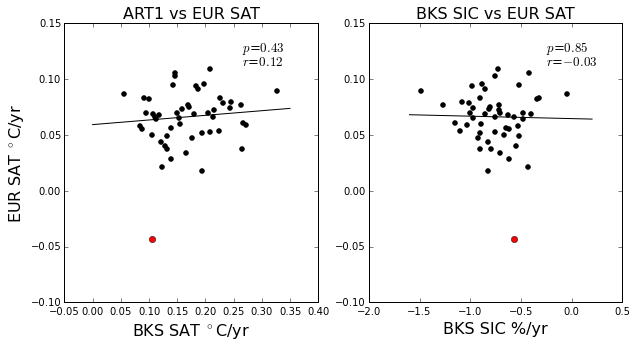

In [29]:
printtofile=False
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
ax.scatter(lebkssatktr,leeursatktr,color='k')
ax.plot(bkssatkmtr,eursatkmtr,marker='o',linestyle='none',color='r',markersize=6)
ax.set_title('ART1 vs EUR SAT',fontsize=16)

testmm,testbb,test_r,test_p = cutl.regress(lebkssatktr,leeursatktr) # mm, bb, r-val, p-val

ax.annotate('$r$=$%.2f$'%(test_r),xy=(.7,.85),xycoords='axes fraction',fontsize=13) #'$%.2f$'%(rvalc1) 
ax.annotate('$p$=$%.2f$'%(test_p),xy=(.7,.9),xycoords='axes fraction',fontsize=13) #'$%.2f$'%(rvalc1) 
ax.set_xlabel('BKS SAT $^\circ$C/yr',fontsize=16)
ax.set_ylabel('EUR SAT $^\circ$C/yr',fontsize=16)
axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

ax=axs[1]
ax.scatter(lebkssicktr,leeursatktr,color='k')
ax.plot(bkssickmtr,eursatkmtr,marker='o',linestyle='none',color='r',markersize=6) 
ax.set_title('BKS SIC vs EUR SAT',fontsize=16)

testmm,testbb,test_r,test_p = cutl.regress(lebkssicktr,leeursatktr) # mm, bb, r-val, p-val

ax.annotate('$r$=$%.2f$'%(test_r),xy=(.7,.85),xycoords='axes fraction',fontsize=13) #'$%.2f$'%(rvalc1) 
ax.annotate('$p$=$%.2f$'%(test_p),xy=(.7,.9),xycoords='axes fraction',fontsize=13) #'$%.2f$'%(rvalc1) 
ax.set_xlabel('BKS SIC %/yr',fontsize=16)
#ax.set_ylabel('EUR SAT $^\circ$C/yr')
axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)
if printtofile:
    fig.savefig('myreg_LE_DJFavg_ART1BKSSIC_EURSATtrend_' + timeselsea +'.pdf')
    fig.savefig('myreg_LE_DJFavg_ART1BKSSIC_EURSATtrend_' + timeselsea +'.png',dpi=300)

    
# @@@@@@ Note that in the Kug paper & here, trends for these two 
# @@@@@@ regions/connections are shown for two different time periods.
# ART1 v EUR SAT: 1998-2013
# ART2 v NA SAT: 1998-2013

# Test these over the full time period too.

# @@@@ make this figure but with BKS/Arctic SIA as the x axis. @@@@

In [30]:
# For Kug Fig 2

import numpy.ma as ma

cutl = reload(cutl)

# ########### OBSERVATIONS

#satk = fldkmdt['sat']
#print satk.shape
#print art1.shape

#ntk = satk.shape[0]
nlatk = len(latkdt['sat'])
nlonk = len(lonkdt['sat'])

#REMINDER: climo has not been removed
# here is definition of art1mon
# art1mon = detrend_monthly(bkssatk[:-6],incr=3) #cutl.detrend(bkssatkrem)


# do this on the winter monthly data instead:
satkmon,remclimsat = rem_monmean(fldkdt['sat'][:-3,...],incr=3)
ntkmon = satkmon.shape[0]

print art1mon.shape,satkmon.shape

#_,_,art1_r,art1_p = cutl.regress(art1,satk.reshape((ntk,nlatk*nlonk)))
art1_mm,art1_r,art1_p = corrmap(art1mon,satkmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
print art1_r.shape
art1_corrsig = ma.masked_where(art1_p>0.05,art1_r)
art1_mmsig = ma.masked_where(art1_p>0.05,art1_mm)

art2_mm,art2_r,art2_p = corrmap(art2mon,satkmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
print art2_r.shape
art2_corrsig = ma.masked_where(art2_p>0.05,art2_r)
art2_mmsig = ma.masked_where(art2_p>0.05,art2_mm)


nyr 34
remclimo.shape (3, 64, 129)
remclimot.shape (102, 64, 129)
(102,) (102, 64, 129)
(64, 129)
(64, 129)


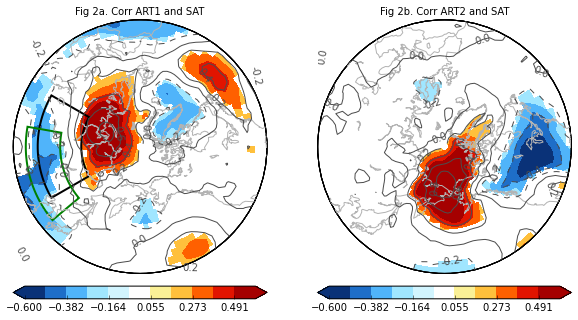

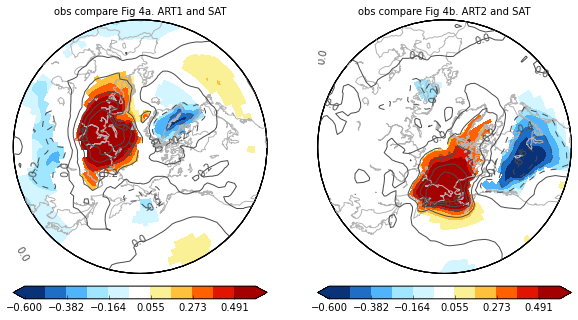

In [34]:
printtofile=False


# Kug et al. Figure 2
levels = [-0.8,-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
cmap = 'blue2red_w11'
cmin=-.6; cmax=.6

# note that spatial SAT here is *not* detrended (monthly climo is removed) but the index is.
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
bm,pc = cplt.kemmap(art1_corrsig,latkdt['sat'],lonkdt['sat'],ptype='nhkug',latlim=30,axis=ax,
            cmin=cmin,cmax=cmax, cmap=cmap,title='Fig 2a. Corr ART1 and SAT')
cplt.add_contours(bm,art1_r,latkdt['sat'],lonkdt['sat'],levels=levels,clab=True)
cplt.add_regionpolym('eurasiamori',bm)
cplt.add_regionpolym('eurasiakug',bm,ec='g')

ax=axs[1]
bm,pc = cplt.kemmap(art2_corrsig,latkdt['sat'],lonkdt['sat'],ptype='nhkug',latlim=30,axis=ax,
            cmin=cmin,cmax=cmax, cmap=cmap,title='Fig 2b. Corr ART2 and SAT')
cplt.add_contours(bm,art2_r,latkdt['sat'],lonkdt['sat'],levels=levels,clab=True)
if printtofile: 
    fig.savefig('myreg_kugetal_Fig2a-b.pdf')

#  For my reference, also plot map of observed SAT regressed on the indices (instead of correlation)
# This is the pattern to compare to the model regressions (in Fig 4)
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
bm,pc = cplt.kemmap(art1_mmsig,latkdt['sat'],lonkdt['sat'],ptype='nhkug',latlim=30,axis=ax,
            cmin=cmin,cmax=cmax, cmap=cmap,title='obs compare Fig 4a. ART1 and SAT')
cplt.add_contours(bm,art1_mm,latkdt['sat'],lonkdt['sat'],levels=levels,clab=True)

ax=axs[1]
bm,pc = cplt.kemmap(art2_mmsig,latkdt['sat'],lonkdt['sat'],ptype='nhkug',latlim=30,axis=ax,
            cmin=cmin,cmax=cmax, cmap=cmap,title='obs compare Fig 4b. ART2 and SAT')
cplt.add_contours(bm,art2_mm,latkdt['sat'],lonkdt['sat'],levels=levels,clab=True)
if printtofile: 
    fig.savefig('myreg_SATregressedonART_cmp_kugetal_Fig4a-b.pdf')


lat: squeezing data upon read all
lon: squeezing data upon read all
THIS DATA IS detrendrem
(102, 50) (102,)
(102, 10, 8192) (102, 8192)
ART1: ens 0 pattern corr w/ obs: 
(1.3739791225215474, 0.02885451555728516, 0.94163026441126518, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(1.1049655458119605, 0.04036869874001172, 0.78085871059685596, 0.0)
ART1: ens 0 pattern corr w/ obs: 
(1.3159639607750202, -0.018857576464525738, 0.90945014504292276, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(1.0918714901882314, 0.00074960560474664206, 0.8013048289945941, 0.0)
ART1: ens 0 pattern corr w/ obs: 
(1.3433632903036028, 0.020611062389013737, 0.92113119632200857, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(1.2379316091153796, -0.0033299570991714295, 0.89552799123483007, 0.0)
ART1: ens 0 pattern corr w/ obs: 
(1.129274596378548, -0.01982226811469838, 0.92254026014278456, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(1.0803820701690297, -0.040129168985518299, 0.84939453091425865, 0.0)


'\nTHIS DATA IS raw\n(99, 50) (99,)\n(99, 10, 8192) (99, 8192)\nART1: ens 0 pattern corr w/ obs: \n(0.99562190613473456, -0.13046272538256432, 0.80475870507699487, 0.0)\nART2: ens 0 pattern corr w/ obs: \n(0.66127690291439556, -0.13645702180650543, 0.67401035430685452, 0.0)\nART1: ens 0 pattern corr w/ obs: \n(1.0812921693558493, -0.11830058823508031, 0.8179804445516663, 0.0)\nART2: ens 0 pattern corr w/ obs: \n(0.63981527044774145, -0.10514262598997329, 0.67075945784384583, 0.0)\nART1: ens 0 pattern corr w/ obs: \n(0.99145444009458927, -0.10924760011219105, 0.80120192192546036, 0.0)\nART2: ens 0 pattern corr w/ obs: \n(0.80238938558392903, -0.16075638351443786, 0.75893872098710313, 0.0)\nART1: ens 0 pattern corr w/ obs: \n(1.0130774730780709, -0.12386939247207361, 0.82249785996626867, 0.0)\nART2: ens 0 pattern corr w/ obs: \n(0.76098923800685325, -0.1338459192725584, 0.76213972381384909, 0.0)\n'

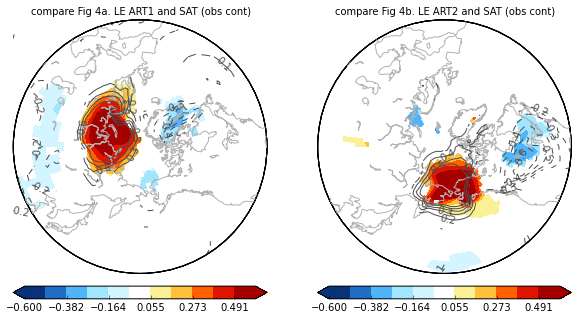

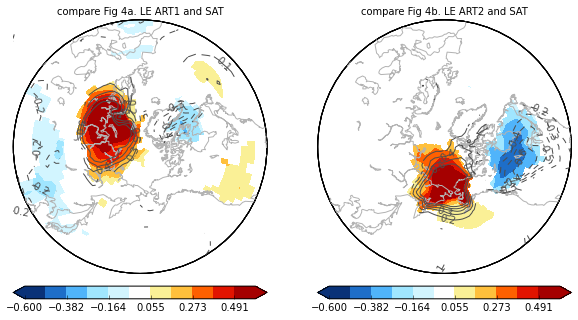

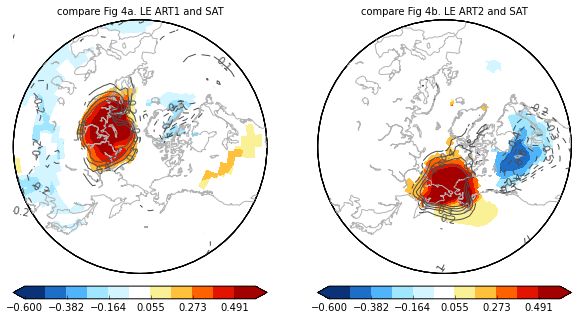

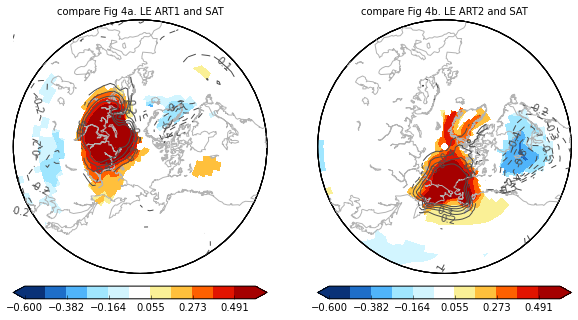

In [35]:
#              In LE, plot map of SAT regressed on ART1, ART2 (detrended monthly)

printtofile=False


if addlespatial:
    
    lelat=le.get_lat(local=True)
    lelon=le.get_lon(local=True)
    lenlat=len(lelat); lenlon=len(lelon)
    klat = latkdt['sat']
    klon = lonkdt['sat']
    # average the 10 ensemble members first??
    # Or Just choose 1 ensemble member? since we got historical-r2 for space, 
    # choose the first one. then choose idx 10 of regional average to match them
    #   (since it's all 50 ens members)
    

    print 'THIS DATA IS ' + dtstr
    
    print leart1mon.shape,leart1mon.mean(axis=1).shape
    print lesatspkmon.shape,lesatspkmon.mean(axis=1).shape
    
    # left with time vs space.flat
    leart1_mm,leart1_r,leart1_p = corrmap(leart1mon[:,10],lesatspkmon[:,0,:],dims=(lenlat,lenlon))
    leart2_mm,leart2_r,leart2_p = corrmap(leart2mon[:,10],lesatspkmon[:,0,:],dims=(lenlat,lenlon))
    leart1_mmsig = ma.masked_where(leart1_p>0.05,leart1_mm)
    leart2_mmsig = ma.masked_where(leart2_p>0.05,leart2_mm)
    
    # Kug et al. Figure 4
    levels = [-0.8,-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
    cmap = 'blue2red_w11'
    cmin=-.6; cmax=.6

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    bm,pc = cplt.kemmap(leart1_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4a. LE ART1 and SAT (obs cont)')
    #cplt.add_contours(bm,leart1_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art1_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    # pattern correlate:
    lepat = leart1_mm[lelat>30,:].flatten()
    obspat = art1_mm[klat>30,:-1].flatten()
    print 'ART1: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    
    
    ax=axs[1]
    bm,pc = cplt.kemmap(leart2_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4b. LE ART2 and SAT (obs cont)')
    #cplt.add_contours(bm,leart2_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art2_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    lepat = leart2_mm[lelat>30,:].flatten()
    obspat = art2_mm[klat>30,:-1].flatten()
    print 'ART2: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    if printtofile:
        fig.savefig('myreg_LE11_ARTregressonspatialSAT' + dtstr + '.pdf')
 
    # try another ensemble member --------------------
    leart1_mm,leart1_r,leart1_p = corrmap(leart1mon[:,11],lesatspkmon[:,1,:],dims=(lenlat,lenlon))    
    leart2_mm,leart2_r,leart2_p = corrmap(leart2mon[:,11],lesatspkmon[:,1,:],dims=(lenlat,lenlon))
    leart1_mmsig = ma.masked_where(leart1_p>0.05,leart1_mm)
    leart2_mmsig = ma.masked_where(leart2_p>0.05,leart2_mm)
    

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    bm,pc = cplt.kemmap(leart1_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4a. LE ART1 and SAT')
    #cplt.add_contours(bm,leart1_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art1_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    # pattern correlate:
    lepat = leart1_mm[lelat>30,:].flatten()
    obspat = art1_mm[klat>30,:-1].flatten()
    print 'ART1: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)

    ax=axs[1]
    bm,pc = cplt.kemmap(leart2_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4b. LE ART2 and SAT')
    #cplt.add_contours(bm,leart2_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art2_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    lepat = leart2_mm[lelat>30,:].flatten()
    obspat = art2_mm[klat>30,:-1].flatten()
    print 'ART2: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    if printtofile:
        fig.savefig('myreg_LE12_ARTregressonspatialSAT' + dtstr + '.pdf')

    
    
    
    # try another ensemble member ----------------------
    leart1_mm,leart1_r,leart1_p = corrmap(leart1mon[:,12],lesatspkmon[:,2,:],dims=(lenlat,lenlon))    
    leart2_mm,leart2_r,leart2_p = corrmap(leart2mon[:,12],lesatspkmon[:,2,:],dims=(lenlat,lenlon))
    leart1_mmsig = ma.masked_where(leart1_p>0.05,leart1_mm)
    leart2_mmsig = ma.masked_where(leart2_p>0.05,leart2_mm)
    

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    bm,pc = cplt.kemmap(leart1_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4a. LE ART1 and SAT')
    #cplt.add_contours(bm,leart1_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art1_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    # pattern correlate:
    lepat = leart1_mm[lelat>30,:].flatten()
    obspat = art1_mm[klat>30,:-1].flatten()
    print 'ART1: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    
    ax=axs[1]
    bm,pc = cplt.kemmap(leart2_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4b. LE ART2 and SAT')
    #cplt.add_contours(bm,leart2_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art2_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    lepat = leart2_mm[lelat>30,:].flatten()
    obspat = art2_mm[klat>30,:-1].flatten()
    print 'ART2: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    if printtofile:
        fig.savefig('myreg_LE13_ARTregressonspatialSAT' + dtstr + '.pdf')
    
    
    
    # try another ensemble member ----------------------
    leart1_mm,leart1_r,leart1_p = corrmap(leart1mon[:,13],lesatspkmon[:,3,:],dims=(lenlat,lenlon))    
    leart2_mm,leart2_r,leart2_p = corrmap(leart2mon[:,13],lesatspkmon[:,3,:],dims=(lenlat,lenlon))
    leart1_mmsig = ma.masked_where(leart1_p>0.05,leart1_mm)
    leart2_mmsig = ma.masked_where(leart2_p>0.05,leart2_mm)
    

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    bm,pc = cplt.kemmap(leart1_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4a. LE ART1 and SAT')
    #cplt.add_contours(bm,leart1_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art1_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    # pattern correlate:
    lepat = leart1_mm[lelat>30,:].flatten()
    obspat = art1_mm[klat>30,:-1].flatten()
    print 'ART1: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    
    ax=axs[1]
    bm,pc = cplt.kemmap(leart2_mmsig,lelat,lelon,ptype='nhkug',latlim=30,axis=ax,
                    cmin=cmin,cmax=cmax,cmap=cmap,title='compare Fig 4b. LE ART2 and SAT')
    #cplt.add_contours(bm,leart2_mm,lelat,lelon,cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    cplt.add_contours(bm,art2_mmsig,latkdt['sat'],lonkdt['sat'],cmin=cmin,cmax=cmax,cmlen=11,clab=True)
    lepat = leart2_mm[lelat>30,:].flatten()
    obspat = art2_mm[klat>30,:-1].flatten()
    print 'ART2: ens 0 pattern corr w/ obs: '
    print cutl.regress(lepat,obspat)
    if printtofile:
        fig.savefig('myreg_LE14_ARTregressonspatialSAT' + dtstr + '.pdf')
    
# SAVE the regression coeffs from RAW (not detrended) data here:
"""
THIS DATA IS raw
(99, 50) (99,)
(99, 10, 8192) (99, 8192)
ART1: ens 0 pattern corr w/ obs: 
(0.99562190613473456, -0.13046272538256432, 0.80475870507699487, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(0.66127690291439556, -0.13645702180650543, 0.67401035430685452, 0.0)
ART1: ens 0 pattern corr w/ obs: 
(1.0812921693558493, -0.11830058823508031, 0.8179804445516663, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(0.63981527044774145, -0.10514262598997329, 0.67075945784384583, 0.0)
ART1: ens 0 pattern corr w/ obs: 
(0.99145444009458927, -0.10924760011219105, 0.80120192192546036, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(0.80238938558392903, -0.16075638351443786, 0.75893872098710313, 0.0)
ART1: ens 0 pattern corr w/ obs: 
(1.0130774730780709, -0.12386939247207361, 0.82249785996626867, 0.0)
ART2: ens 0 pattern corr w/ obs: 
(0.76098923800685325, -0.1338459192725584, 0.76213972381384909, 0.0)
"""

In [36]:
#   For Kug Fig 3:

#slpk = fldkmdt['slp']
#z500k = fldkmdt['z500']; zstr='Z500'
#z500k = fldkmdt['z300']; zstr='Z300' # ACTUALLY Z300
#print slpk.shape

usedtr=False # For obs: use detrended SLP / Z300 or use the climo removed??

slpkmon = fldkdt['slp'][:-3,...] # to be consistent w/ the art index
z500kmon = fldkdt['z300'][:-3,...]

print slpkmon.shape
print art1mon.shape

ntkmon = slpkmon.shape[0]

# not sure I actually want to remove the climo mean.
# maybe instead should do the monthly detrend?

slpkremmon,remclimslp = rem_monmean(slpkmon,incr=3)
z500kremmon,remclimz = rem_monmean(z500kmon,incr=3); zstr='Z300' # ACTUALLY Z300

slpkmondtr = detrend_monthly(slpkmon,incr=3)
z500kmondtr = detrend_monthly(z500kmon,incr=3)

# normalized ART indices or not? doesn't say so but it
#   seems like normalized gives the right magnitude
# Use the detrended monthly ART indices instead of seasonal avg:

if not usedtr: # this one might match a little better
    print 'NOTE THE ART INDICES ARE NORMALIZED'
    art1slp_mm,art1slp_r,art1slp_p = corrmap(art1mon/art1mon.std(),slpkremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art1slp_mmsig = ma.masked_where(art1slp_p>0.05,art1slp_mm)

    art2slp_mm,art2slp_r,art2slp_p = corrmap(art2mon/art2mon.std(),slpkremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art2slp_mmsig = ma.masked_where(art2slp_p>0.05,art2slp_mm)


    art1z500_mm,art1z500_r,art1z500_p = corrmap(art1mon/art1mon.std(),z500kremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art1z500_mmsig = ma.masked_where(art1z500_p>0.05,art1z500_mm)

    art2z500_mm,art2z500_r,art2z500_p = corrmap(art2mon/art2mon.std(),z500kremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art2z500_mmsig = ma.masked_where(art2z500_p>0.05,art2z500_mm)

    """ The magnitude is def wrong if do not use normalized indices
    print 'NOTE THE ART INDICES ARE NOT NORMALIZED'
    art1slp_mm,art1slp_r,art1slp_p = corrmap(art1mon,slpkremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art1slp_mmsig = ma.masked_where(art1slp_p>0.05,art1slp_mm)

    art2slp_mm,art2slp_r,art2slp_p = corrmap(art2mon,slpkremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art2slp_mmsig = ma.masked_where(art2slp_p>0.05,art2slp_mm)


    art1z500_mm,art1z500_r,art1z500_p = corrmap(art1mon,z500kremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art1z500_mmsig = ma.masked_where(art1z500_p>0.05,art1z500_mm)

    art2z500_mm,art2z500_r,art2z500_p = corrmap(art2mon,z500kremmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art2z500_mmsig = ma.masked_where(art2z500_p>0.05,art2z500_mm)"""

else: # do not use. Don't want to detrend the spatial data.
    # Use the detrended spatial field instead of climo removed:
    art1slp_mm,art1slp_r,art1slp_p = corrmap(art1mon/art1mon.std(),slpkmondtr.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art1slp_mmsig = ma.masked_where(art1slp_p>0.05,art1slp_mm)

    art2slp_mm,art2slp_r,art2slp_p = corrmap(art2mon/art2mon.std(),slpkmondtr.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art2slp_mmsig = ma.masked_where(art2slp_p>0.05,art2slp_mm)


    art1z500_mm,art1z500_r,art1z500_p = corrmap(art1mon/art1mon.std(),z500kmondtr.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art1z500_mmsig = ma.masked_where(art1z500_p>0.05,art1z500_mm)

    art2z500_mm,art2z500_r,art2z500_p = corrmap(art2mon/art2mon.std(),z500kmondtr.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
    art2z500_mmsig = ma.masked_where(art2z500_p>0.05,art2z500_mm)



(102, 64, 129)
(102,)
nyr 34
remclimo.shape (3, 64, 129)
remclimot.shape (102, 64, 129)
nyr 34
remclimo.shape (3, 64, 129)
remclimot.shape (102, 64, 129)
nyr 34
retdtr.shape (102, 64, 129)
nyr 34
retdtr.shape (102, 64, 129)
NOTE THE ART INDICES ARE NORMALIZED


usedtr= False


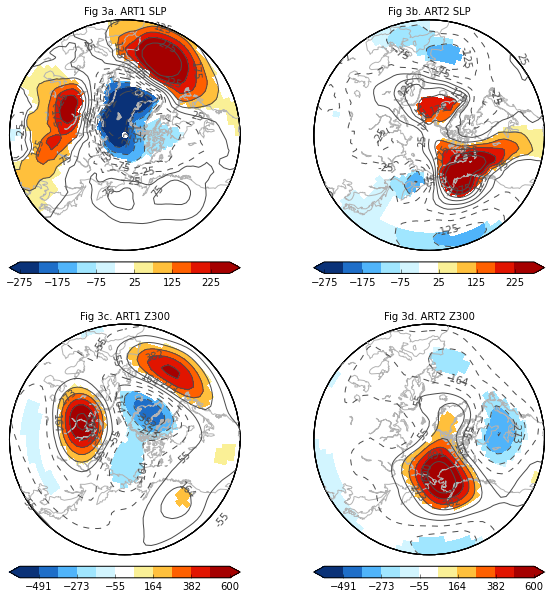

In [37]:
printtofile=False


print 'usedtr= ' + str(usedtr)

# Kug et al. 2015 Figure 3
cplt=reload(cplt)

# convert to Pa
cmap = 'blue2red_w11'

cmin=-275; cmax=275
fmt='%1.0f'


fig,axs=plt.subplots(2,2,figsize=(10,10))
ax=axs[0,0]
bm,pc = cplt.kemmap(art1slp_mmsig*100,latkdt['sat'],lonkdt['sat'], title='Fig 3a. ART1 SLP',
                    ptype='nhkug',latlim=30,axis=ax,cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,art1slp_mm*100,latkdt['sat'],lonkdt['sat'],clab=True,
                  cmin=cmin,cmax=cmax,axis=ax,fmt=fmt,cmlen=11)

ax=axs[0,1]
bm,pc = cplt.kemmap(art2slp_mmsig*100,latkdt['sat'],lonkdt['sat'], title='Fig 3b. ART2 SLP',
                    ptype='nhkug',latlim=30,axis=ax,cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,art2slp_mm*100,latkdt['sat'],lonkdt['sat'],clab=True,
                  cmin=cmin,cmax=cmax,axis=ax,fmt=fmt,cmlen=11)

# Mult by 10 to sort of match Kug. 
cmin=-600; cmax=600
ax=axs[1,0]
bm,pc = cplt.kemmap(art1z500_mmsig*graveraint,latkdt['sat'],lonkdt['sat'], title='Fig 3c. ART1 '+zstr,
                    ptype='nhkug',latlim=30,axis=ax,cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,art1z500_mm*graveraint,latkdt['sat'],lonkdt['sat'],clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)

ax=axs[1,1]
bm,pc = cplt.kemmap(art2z500_mmsig*graveraint,latkdt['sat'],lonkdt['sat'], title='Fig 3d. ART2 '+zstr,
                    ptype='nhkug',latlim=30,axis=ax,cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,art2z500_mm*graveraint,latkdt['sat'],lonkdt['sat'],clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)

if printtofile:
    fig.savefig('myreg_kugetal_Fig3a-d.pdf')

In [ ]:
# Two things to do:
#    1. produce ART1 & EUR and ART2 & NA correlations /maps from AGCM
#
#    2. produce those correlations/maps ACROSS the LE trends
#       a. Calc trend of BKS SAT in e/ ensemble member
#       b. Calc trend of EUR SAT in e/ ensemble member
#       c. scatter these trend values and compute the regression line (50 data points)
#       d. repeat for CHUCK SAT and NA SAT
#     ---- above are all regional means
#       e. Calc SLP, Z300 trend in e/ grid cell for e/ ensemble member (end w/ 50 trend maps)
#       f. Regress e. onto BKS SAT and CHUCK SAT trends across ensemble dimension (end w/ map of correlations or slopes)

# @@@ Question: use DJF average? otherwise have 3 trends, one for D,J,F


In [22]:
# ------- AGCM?
import pandas as pd
import loadmodeldata as lmd


field='tas'
sims=('R1','R2','R3','R4','R5','NSIDC')
#sims=('E1','E2','E3','E4','E5')


simconv1=1
if field=='tas': simfield1='st'; simncfield1='ST'
elif field=='zg50000.00': simfield1='gz50000'; simncfield1='PHI'; simconv1=1/con.get_g()
elif field=='sia': simfield1='sicn'; simncfield1='SICN'; print '@@ danger, sia actually sicn average'
elif field=='sic': simfield1='sicn'; simncfield1='SICN';
else: print 'cannot addsims for ' + field;


# Do control and pert separately

print simncfield1

# ==== REGIONAL
# BKS SAT
#    CTL
bkssatcdf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly',
                                         region=regionskug['BKS'],filetype='ctl'))*simconv1
print 'bkssatcdf.shape ' + str(bkssatcdf.shape)

bkssatcmon = selectmonths(bkssatcdf.values,incr=3,start=11)
#bkssatcmon = selectmonths(bkssatcdf.values,incr=1,start=11) # @@@ JustDec?

print bkssatcmon.shape
bkssatcsea = selectmonths(bkssatcdf.values,incr=3,start=11,retavg=True)
print bkssatcsea.shape

#    PERT
bkssatpdf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly',
                                     region=regionskug['BKS'], filetype='pert'))*simconv1
bkssatpmon = selectmonths(bkssatpdf.values,incr=3,start=11)
#bkssatpmon = selectmonths(bkssatpdf.values,incr=1,start=11) # @@@ Just Dec?

bkssatpsea = selectmonths(bkssatpdf.values,incr=3,start=11,retavg=True)

# EUR SAT
#    CTL
eursatcdf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly', 
                                         region=regionskug['EUR'],filetype='ctl'))*simconv1
eursatcmon = selectmonths(eursatcdf.values,incr=3,start=11)
#eursatcmon = selectmonths(eursatcdf.values,incr=1,start=11) # @@@ Just Dec?

eursatcsea = selectmonths(eursatcdf.values,incr=3,start=11,retavg=True)

#    PERT
eursatpdf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly', 
                                     region=regionskug['EUR'], filetype='pert'))*simconv1
eursatpmon = selectmonths(eursatpdf.values,incr=3,start=11)
#eursatpmon = selectmonths(eursatpdf.values,incr=1,start=11)# @@@ Just Dec?

eursatpsea = selectmonths(eursatpdf.values,incr=3,start=11,retavg=True)

# Remove monthly climo?

bkssatcmonrem,_ = rem_monmean(bkssatcmon,incr=3)
bkssatpmonrem,_ = rem_monmean(bkssatpmon,incr=3)
eursatcmonrem,_ = rem_monmean(eursatcmon,incr=3)
eursatpmonrem,_ = rem_monmean(eursatpmon,incr=3)

#bkssatcmonrem,_ = rem_monmean(bkssatcmon,incr=1) # @@@ Just Dec?
#bkssatpmonrem,_ = rem_monmean(bkssatpmon,incr=1)
#eursatcmonrem,_ = rem_monmean(eursatcmon,incr=1)
#eursatpmonrem,_ = rem_monmean(eursatpmon,incr=1)


ST
@@ probably should invert the order such that it is field, season, sim?
('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (1440, 64, 128)
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (1440, 64, 128)
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (1440, 64, 128)
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (1440, 64, 128)
R5
/HOME/rkm/work/

In [8]:
print bkssatcdf.columns


Index([u'NSIDC', u'R1', u'R2', u'R3', u'R4', u'R5'], dtype='object')


In [8]:
# ==== SPATIAL
#    SAT
import numpy.ma as ma

latsim = con.get_t63lat()
lonsim = con.get_t63lon()


satcdf = lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly', 
                      filetype='ctl')#*simconv1
print satcdf.keys()

nlatsim = satcdf[sims[0]].shape[1]
nlonsim = satcdf[sims[0]].shape[2]
#print satcvals.shape

satpdf = lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='monthly', 
                                         filetype='pert')

print lonsim.shape

spmmc1={}; spmmp1={}; spmmc1sig={}; spmmp1sig={} # BKS
spmmcsea1={}; spmmpsea1={}; spmmcsea1sig={}; spmmpsea1sig={}
for eii,ekey in enumerate(bkssatcdf.columns):
    
    print ekey
    spsatc = satcdf[ekey]
    print spsatc.shape
    satcmon = selectmonths(spsatc,incr=3,start=11)
    satcmonrem,_ = rem_monmean(satcmon,incr=3)
    #satcmon = selectmonths(spsatc,incr=1,start=11) # just Dec? @@@
    #satcmonrem,_ = rem_monmean(satcmon,incr=1) # just Dec? @@@
    
    
    print 'satcmonrem.shape ' + str(satcmonrem.shape)
    print spsatc.shape[0]
    spsatcrs = satcmonrem.reshape((satcmon.shape[0],nlatsim*nlonsim))
    print spsatcrs.shape
    satcsea = selectmonths(spsatc,incr=3,start=11,retavg=True)
    spsatcsears = satcsea.reshape((satcsea.shape[0],nlatsim*nlonsim))
    
    spsatp = satpdf[ekey]
    print spsatp.shape

    satpmon = selectmonths(spsatp,incr=3,start=11)
    satpmonrem,_ = rem_monmean(satpmon,incr=3)
    #satpmon = selectmonths(spsatp,incr=1,start=11) # just Dec? @@@
    #satpmonrem,_ = rem_monmean(satpmon,incr=1) # just Dec? @@@
    spsatprs = satpmonrem.reshape((satpmon.shape[0],nlatsim*nlonsim))
    print spsatprs.shape
    satpsea = selectmonths(spsatp,incr=3,start=11,retavg=True)
    spsatpsears = satpsea.reshape((satpsea.shape[0],nlatsim*nlonsim))
    
    # regress on BKS SAT, monthly
    rsatc = bkssatcmonrem[:,eii]
    rsatp = bkssatpmonrem[:,eii]
    
    spmmc1[ekey],sp_r,sp_p = corrmap(rsatc,spsatcrs,(nlatsim,nlonsim))
    spmmc1sig[ekey] = ma.masked_where(sp_p>0.05,spmmc1[ekey])
    
    spmmp1[ekey],sp_r,sp_p = corrmap(rsatp,spsatprs,(nlatsim,nlonsim))
    spmmp1sig[ekey] = ma.masked_where(sp_p>0.05,spmmp1[ekey])

    # regress on BKS SAT, SEASONAL
    rsatc = bkssatcsea[:,eii]
    rsatp = bkssatpsea[:,eii]
    
    spmmcsea1[ekey],sp_r,sp_p = corrmap(rsatc,spsatcsears,(nlatsim,nlonsim))
    spmmcsea1sig[ekey] = ma.masked_where(sp_p>0.05,spmmcsea1[ekey])
    
    spmmpsea1[ekey],sp_r,sp_p = corrmap(rsatp,spsatpsears,(nlatsim,nlonsim))
    spmmpsea1sig[ekey] = ma.masked_where(sp_p>0.05,spmmpsea1[ekey])
    
    
    
    

lat: squeezing data upon read all
lon: squeezing data upon read all
@@ probably should invert the order such that it is field, season, sim?
('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc
NSIDC
/HOME/rkm/work/DATA/CanAM4/kemnsidcctl/ts/kemnsidcctl_st_001-121_ts.nc
['R4', 'R5', 'NSIDC', 'R1', 'R2', 'R3']
@@ probably should invert the order such that it is field, season, sim?
('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc

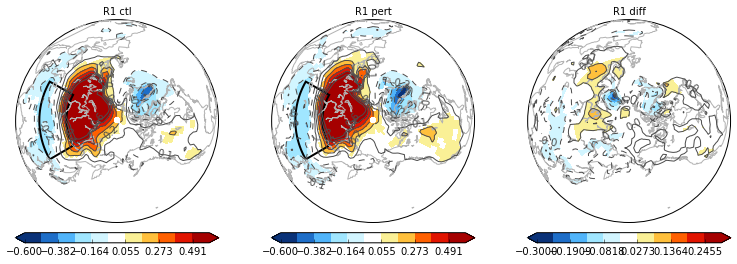

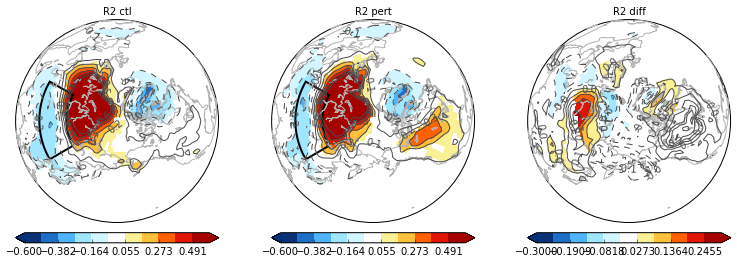

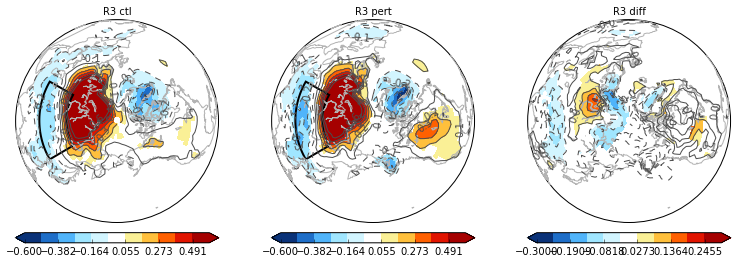

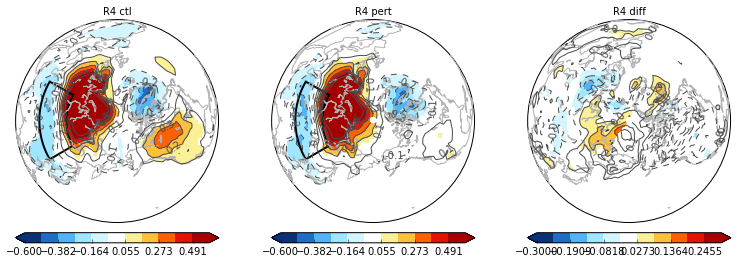

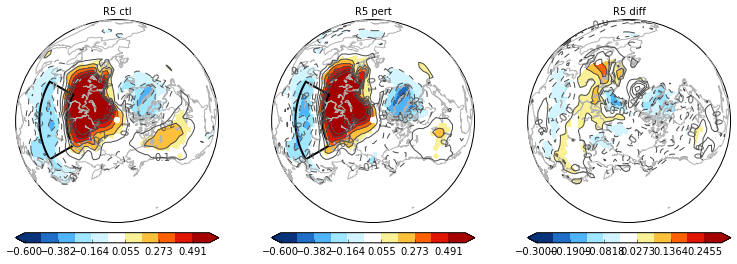

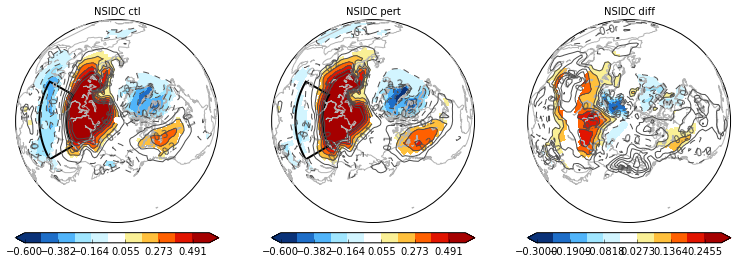

In [9]:
printtofile=False


cmin=-0.6; cmax=0.6; cmap='blue2red_w11'
cmind=-0.3; cmaxd=0.3; 

fmt='%1.1f'
   


for eii,ekey in enumerate(sims):
    
    fig,axs=plt.subplots(1,3,figsize=(13,4))
    ax=axs[0]
    bm,pc = cplt.kemmap(spmmc1sig[ekey],latsim,lonsim,ptype='nhkug',axis=ax,title=ekey+' ctl',
                    cmin=cmin,cmax=cmax,cmap=cmap)
    cplt.add_contours(bm,spmmc1[ekey],latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
    cplt.add_regionpolym(regionskug['EUR'],bm)


    ax=axs[1]
    bm,pc = cplt.kemmap(spmmp1sig[ekey],latsim,lonsim,axis=ax,ptype='nhkug',title=ekey+' pert',
                cmin=cmin,cmax=cmax,cmap=cmap)
    cplt.add_contours(bm,spmmp1[ekey],latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
    cplt.add_regionpolym(regionskug['EUR'],bm)
    
    ax=axs[2]
    bm,pc = cplt.kemmap(spmmp1sig[ekey]-spmmc1sig[ekey],latsim,lonsim,axis=ax,ptype='nhkug',title=ekey+' diff',
                cmin=cmind,cmax=cmaxd,cmap=cmap)
    cplt.add_contours(bm,spmmp1[ekey]-spmmc1[ekey],latsim,lonsim,clab=True,
                  axis=ax,cmin=cmind,cmax=cmaxd,fmt=fmt,cmlen=11)
    
    if printtofile:
        fig.savefig('myreg_AGCM_' + ekey + '_regressonspatialSAT_ctlpertdiff_DJFmon.pdf')
        


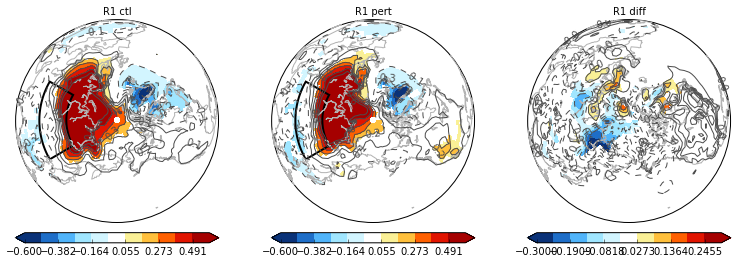

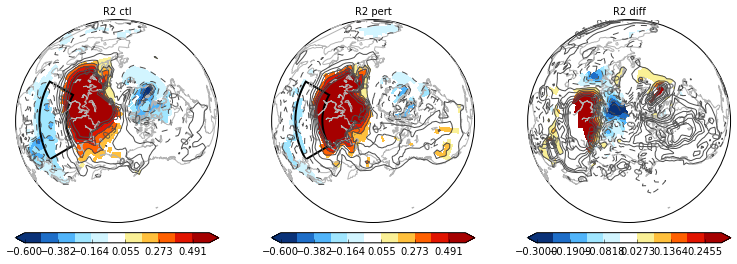

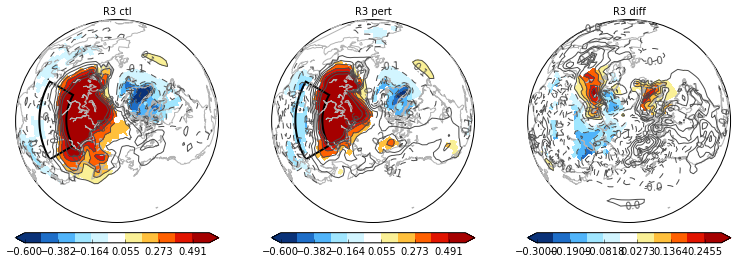

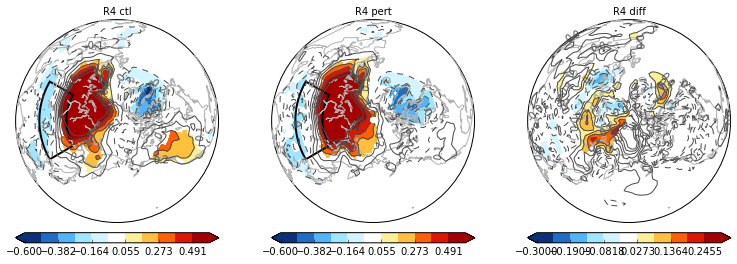

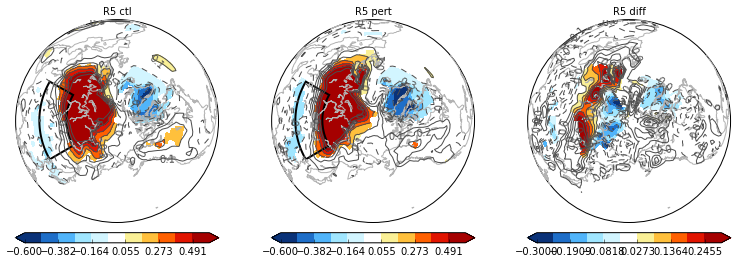

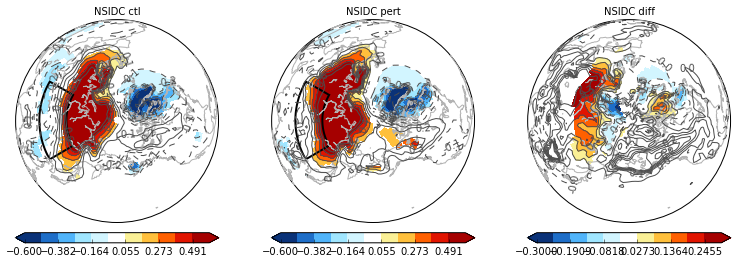

In [10]:
# DJF SEASONAL
printtofile=False

for eii,ekey in enumerate(sims):
    
    fig,axs=plt.subplots(1,3,figsize=(13,4))
    ax=axs[0]
    bm,pc = cplt.kemmap(spmmcsea1sig[ekey],latsim,lonsim,ptype='nhkug',axis=ax,title=ekey+' ctl',
                    cmin=cmin,cmax=cmax,cmap=cmap)
    cplt.add_contours(bm,spmmcsea1[ekey],latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
    cplt.add_regionpolym(regionskug['EUR'],bm)


    ax=axs[1]
    bm,pc = cplt.kemmap(spmmpsea1sig[ekey],latsim,lonsim,axis=ax,ptype='nhkug',title=ekey+' pert',
                cmin=cmin,cmax=cmax,cmap=cmap)
    cplt.add_contours(bm,spmmpsea1[ekey],latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
    cplt.add_regionpolym(regionskug['EUR'],bm)
    
    ax=axs[2]
    bm,pc = cplt.kemmap(spmmpsea1sig[ekey]-spmmcsea1sig[ekey],latsim,lonsim,axis=ax,ptype='nhkug',title=ekey+' diff',
                cmin=cmind,cmax=cmaxd,cmap=cmap)
    cplt.add_contours(bm,spmmpsea1[ekey]-spmmcsea1[ekey],latsim,lonsim,clab=True,
                  axis=ax,cmin=cmind,cmax=cmaxd,fmt=fmt,cmlen=11)
    
    if printtofile:
        fig.savefig('myreg_AGCM_' + ekey + '_regressonspatialSAT_ctlpertdiff_DJFsea.pdf')
        


(5, 64, 129)

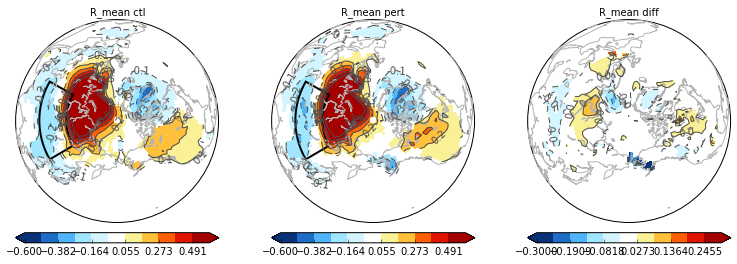

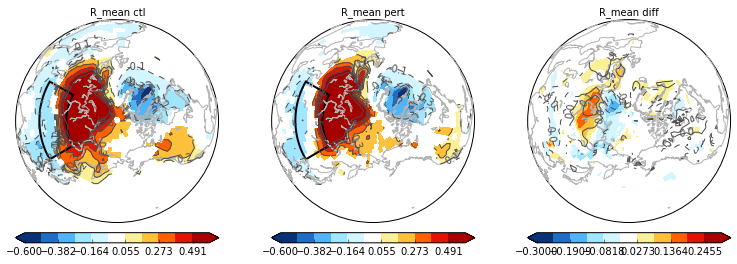

In [11]:
# do the mean of all 5 AGCM simulations
printtofile=False
#cmin=-0.6; cmax=0.6; cmap='blue2red_w11'
#cmind=-0.3; cmaxd=0.3; 
fmt='%1.1f'


if 'R1' in sims:
    spmmc1mean = ma.array(spmmc1sig.values())[1:,...].mean(axis=0) # leave off NSIDC sim
    spmmp1mean = ma.array(spmmp1sig.values())[1:,...].mean(axis=0)
    spmmcsea1mean = ma.array(spmmcsea1sig.values())[1:,...].mean(axis=0) # leave off NSIDC sim
    spmmpsea1mean = ma.array(spmmpsea1sig.values())[1:,...].mean(axis=0)    
else:
    spmmc1mean = ma.array(spmmc1sig.values()).mean(axis=0) 
    spmmp1mean = ma.array(spmmp1sig.values()).mean(axis=0)
    spmmcsea1mean = ma.array(spmmcsea1sig.values()).mean(axis=0) 
    spmmpsea1mean = ma.array(spmmpsea1sig.values()).mean(axis=0)    
    
    
fig,axs=plt.subplots(1,3,figsize=(13,4))
ax=axs[0]
bm,pc = cplt.kemmap(spmmc1mean,latsim,lonsim,ptype='nhkug',axis=ax,title=sims[0][0]+'_mean ctl',
                    cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmc1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)

cplt.add_regionpolym(regionskug['EUR'],bm)

ax=axs[1]
bm,pc = cplt.kemmap(spmmp1mean,latsim,lonsim,axis=ax,ptype='nhkug',title=sims[0][0]+'_mean pert',
                cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmp1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
cplt.add_regionpolym(regionskug['EUR'],bm)

ax=axs[2]
bm,pc = cplt.kemmap(spmmp1mean-spmmc1mean,latsim,lonsim,axis=ax,ptype='nhkug',title=sims[0][0]+'_mean diff',
                cmin=cmind,cmax=cmaxd,cmap=cmap)
cplt.add_contours(bm,spmmp1mean-spmmc1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmind,cmax=cmaxd,fmt=fmt,cmlen=11)
    
if printtofile:
    fig.savefig('myreg_AGCM_' + sims[0][0] + 'mean_regressonspatialSAT_ctlpertdiff_DJFmon.pdf')

    
    

fig,axs=plt.subplots(1,3,figsize=(13,4))
ax=axs[0]
bm,pc = cplt.kemmap(spmmcsea1mean,latsim,lonsim,ptype='nhkug',axis=ax,title=sims[0][0]+'_mean ctl',
                    cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmcsea1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)

cplt.add_regionpolym(regionskug['EUR'],bm)

ax=axs[1]
bm,pc = cplt.kemmap(spmmpsea1mean,latsim,lonsim,axis=ax,ptype='nhkug',title=sims[0][0]+'_mean pert',
                cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmpsea1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
cplt.add_regionpolym(regionskug['EUR'],bm)

ax=axs[2]
bm,pc = cplt.kemmap(spmmpsea1mean-spmmcsea1mean,latsim,lonsim,axis=ax,ptype='nhkug',title=sims[0][0]+'_mean diff',
                cmin=cmind,cmax=cmaxd,cmap=cmap)
cplt.add_contours(bm,spmmp1mean-spmmc1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmind,cmax=cmaxd,fmt=fmt,cmlen=11)
    
if printtofile:
    fig.savefig('myreg_AGCM_' + sims[0][0] + 'mean_regressonspatialSAT_ctlpertdiff_DJFsea.pdf')
       

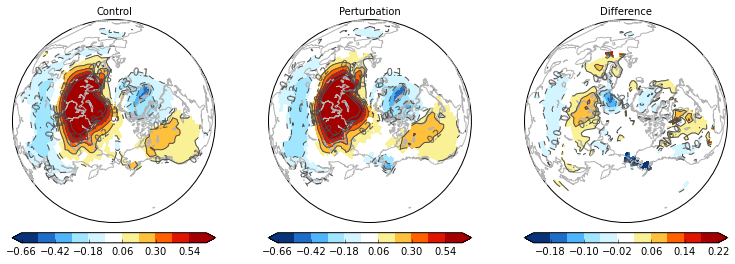

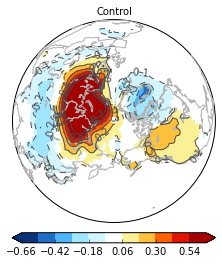

In [20]:
# FOR PAPER SUPP (?) and REBUTTAL
cmin=-0.66; cmax=0.66; cmap='blue2red_w11'
#cmin=-.99; cmax=0.99;
cmind=-0.22; cmaxd=0.22; 
fmt='%1.1f'

printtofile=False

fig,axs=plt.subplots(1,3,figsize=(13,4))
ax=axs[0]
bm,pc = cplt.kemmap(spmmc1mean,latsim,lonsim,ptype='nhkug',axis=ax,title='Control',
                    cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmc1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)

#cplt.add_regionpolym('eurasiakug',bm)

ax=axs[1]
bm,pc = cplt.kemmap(spmmp1mean,latsim,lonsim,axis=ax,ptype='nhkug',title='Perturbation',
                cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmp1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)
#cplt.add_regionpolym('eurasiakug',bm)

ax=axs[2]
bm,pc = cplt.kemmap(spmmp1mean-spmmc1mean,latsim,lonsim,axis=ax,ptype='nhkug',title='Difference',
                cmin=cmind,cmax=cmaxd,cmap=cmap)
cplt.add_contours(bm,spmmp1mean-spmmc1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmind,cmax=cmaxd,fmt=fmt,cmlen=11)
    
if printtofile:
    fig.savefig('myreg_AGCM_papermean_regressonspatialSAT_ctlpertdiff.pdf')
    fig.savefig('myreg_AGCM_papermean_regressonspatialSAT_ctlpertdiff.png',dpi=300)

    

# Just the control run

printtofile=True

fig,axs=plt.subplots(1,1,figsize=(4,4))
ax=axs
bm,pc = cplt.kemmap(spmmc1mean,latsim,lonsim,ptype='nhkug',axis=ax,title='Control',
                    cmin=cmin,cmax=cmax,cmap=cmap)
cplt.add_contours(bm,spmmc1mean,latsim,lonsim,clab=True,
                  axis=ax,cmin=cmin,cmax=cmax,fmt=fmt,cmlen=11)

#cplt.add_regionpolym('eurasiakug',bm)

    
if printtofile:
    fig.savefig('myreg_AGCM_papermean_regressonspatialSAT_ctl.pdf')
    fig.savefig('myreg_AGCM_papermean_regressonspatialSAT_ctl',dpi=300)



In [13]:
print bkssatcdf.columns
print eursatcdf.columns

print bkssatpdf.columns
print eursatpdf.columns

# Now just calculate 1D correlation/regression coef 
# for D,J,F ; DJF; running mean

pmmsea = np.zeros(len(sims)); pbbsea=np.zeros(len(sims));
p_rsea=np.zeros(len(sims)); p_psea=np.zeros(len(sims));
cmmsea = np.zeros(len(sims)); cbbsea=np.zeros(len(sims));
c_rsea=np.zeros(len(sims)); c_psea=np.zeros(len(sims));
dmmsea = np.zeros(len(sims)); dbbsea=np.zeros(len(sims));
d_rsea=np.zeros(len(sims)); d_psea=np.zeros(len(sims));

pmmmo = np.zeros(len(sims)); pbbmo=np.zeros(len(sims));
p_rmo=np.zeros(len(sims)); p_pmo=np.zeros(len(sims));
cmmmo = np.zeros(len(sims)); cbbmo=np.zeros(len(sims));
c_rmo=np.zeros(len(sims)); c_pmo=np.zeros(len(sims));
dmmmo = np.zeros(len(sims)); dbbmo=np.zeros(len(sims));
d_rmo=np.zeros(len(sims)); d_pmo=np.zeros(len(sims));

bkssatseadiff=np.zeros(len(sims)); eursatseadiff=np.zeros(len(sims));
infeursatseadiff=np.zeros(len(sims)); infeursatseadiff2=np.zeros(len(sims)); 
for eii,ekey in enumerate(bkssatcdf.columns):

    print str(eii),ekey
    
    # monthly D,J,F
    pmmmo[eii],pbbmo[eii],p_rmo[eii],p_pmo[eii] = cutl.regress(eursatpmonrem[:,eii],bkssatpmonrem[:,eii])
    cmmmo[eii],cbbmo[eii],c_rmo[eii],c_pmo[eii] = cutl.regress(eursatcmonrem[:,eii],bkssatcmonrem[:,eii])
    dmmmo[eii],dbbmo[eii],d_rmo[eii],d_pmo[eii] = cutl.regress(eursatpmonrem[:,eii]-eursatcmonrem[:,eii],
                                                               bkssatpmonrem[:,eii]-bkssatcmonrem[:,eii])
    
    # SEASONAL DJF
    pmmsea[eii],pbbsea[eii],p_rsea[eii],p_psea[eii] = cutl.regress(eursatpsea[:,eii],bkssatpsea[:,eii])
    cmmsea[eii],cbbsea[eii],c_rsea[eii],c_psea[eii] = cutl.regress(eursatcsea[:,eii],bkssatcsea[:,eii])
    dmmsea[eii],dbbsea[eii],d_rsea[eii],d_psea[eii] = cutl.regress(eursatpsea[:,eii]-eursatcsea[:,eii],
                                                                   bkssatpsea[:,eii]-bkssatcsea[:,eii])
    
    bkssatseadiff[eii] = bkssatpsea[:,eii].mean(axis=0)-bkssatcsea[:,eii].mean(axis=0)
    eursatseadiff[eii] = eursatpsea[:,eii].mean(axis=0)-eursatcsea[:,eii].mean(axis=0)
    print 'pert slope - ctl slope'
    print (pmmsea[eii]-cmmsea[eii])
    
    infeursatseadiff[eii] = bkssatseadiff[eii]*(pmmsea[eii]-cmmsea[eii])
    infeursatseadiff2[eii] = bkssatseadiff[eii]*dmmsea[eii]
    


Index([u'NSIDC', u'R1', u'R2', u'R3', u'R4', u'R5'], dtype='object')
Index([u'NSIDC', u'R1', u'R2', u'R3', u'R4', u'R5'], dtype='object')
Index([u'NSIDC', u'R1', u'R2', u'R3', u'R4', u'R5'], dtype='object')
Index([u'NSIDC', u'R1', u'R2', u'R3', u'R4', u'R5'], dtype='object')
0 NSIDC
pert slope - ctl slope
0.271392037445
1 R1
pert slope - ctl slope
-0.164113796738
2 R2
pert slope - ctl slope
0.329667404601
3 R3
pert slope - ctl slope
-0.241711290391
4 R4
pert slope - ctl slope
-0.0469008223766
5 R5
pert slope - ctl slope
0.0323591276189


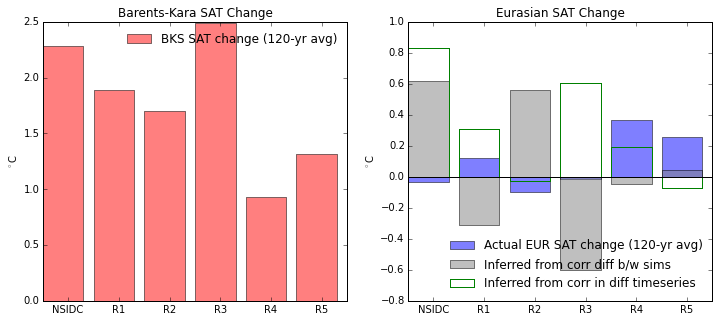

In [14]:
# @@@ multiply pmmsea by actual change in BKS SAT -- how much cooling?
#  What is the inferred EUR cooling?

printtofile=True

barx = np.arange(len(sims))
fig,axs=plt.subplots(1,2,figsize=(12,5))
ax=axs[0]
ax.bar(barx,bkssatseadiff,color='r',alpha=0.5)
ax.set_xticks(np.arange(0,len(sims))+.5)
ax.set_xticklabels(bkssatcdf.columns)
ax.set_ylabel('$^\circ$C')
ax.legend(('BKS SAT change (120-yr avg)',),frameon=False,loc='best')
ax.set_title('Barents-Kara SAT Change')

#fig,ax=plt.subplots(1,1)
ax=axs[1]
act = ax.bar(barx,eursatseadiff,color='b',alpha=0.5) # actual 120-yr EUR SAT change
inf = ax.bar(barx,infeursatseadiff,color='0.5',alpha=0.5)
inf2 = ax.bar(barx,infeursatseadiff2,color='none',edgecolor='g')
ax.axhline(y=0,color='k')
ax.set_xticks(np.arange(0,len(sims))+.5)
ax.set_xticklabels(bkssatcdf.columns)
ax.set_ylabel('$^\circ$C')
ax.legend((act,inf,inf2),('Actual EUR SAT change (120-yr avg)',
                          'Inferred from corr diff b/w sims',
                          'Inferred from corr in diff timeseries'),
          loc='lower right',frameon=False)
ax.set_title('Eurasian SAT Change')
if printtofile:
    fig.savefig('myreg_AGCM_BKSSAT_EURSATinferred_DJF.pdf')

(119, 6)
(110, 6)
(100, 6)
(80, 6)
(40, 6)


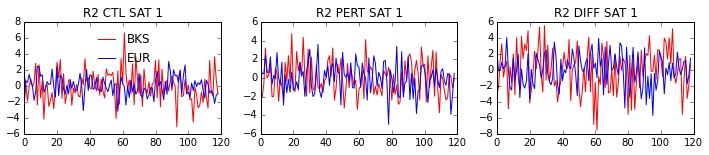

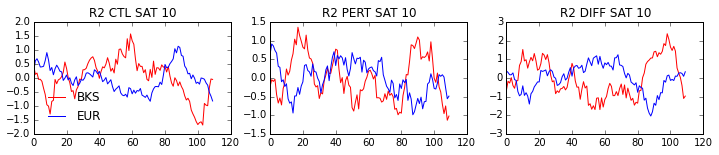

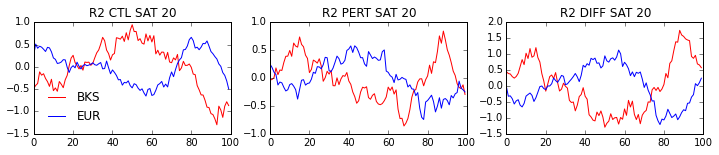

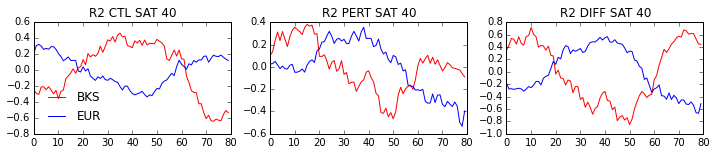

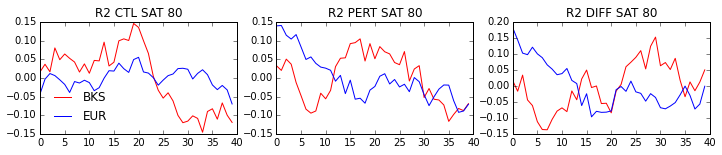

In [15]:
# running means
pmm={}; pbb={}; p_r={};p_p={}
cmm={}; cbb={}; c_r={};c_p={}
dmm={}; dbb={}; d_r={};d_p={}
eursatpsearun={}; eursatcsearun={};eursatdsearun={};
bkssatpsearun={}; bkssatcsearun={};bkssatdsearun={};

ens=2
#(1,5,10,20,40)
runs = (1,10,20,40,80)
for ii,win in enumerate(runs):

    eursatpsearun[win] = runmean(eursatpsea,axis=0,window=win)
    bkssatpsearun[win] = runmean(bkssatpsea,axis=0,window=win)
    eursatcsearun[win] = runmean(eursatcsea,axis=0,window=win)
    bkssatcsearun[win] = runmean(bkssatcsea,axis=0,window=win)
    bkssatdsearun[win] = runmean(bkssatpsea-bkssatcsea,axis=0,window=win)
    eursatdsearun[win] = runmean(eursatpsea-eursatcsea,axis=0,window=win)
    
    pmm[win], pbb[win], p_r[win], p_p[win] = cutl.regress(eursatpsearun[win],
                                                          bkssatpsearun[win])
    cmm[win], cbb[win], c_r[win], c_p[win] = cutl.regress(eursatcsearun[win],
                                                          bkssatcsearun[win])
    dmm[win], dbb[win], d_r[win], d_p[win] = cutl.regress(eursatdsearun[win],
                                                          bkssatdsearun[win])

    print runmean(eursatpsea,axis=0,window=win).shape

    #fig,axs=plt.subplots(1,2,figsize=(10,2))
    #ax=axs[0]
    #ax.plot(bkssatcsearun[win][:,ens])#,color='k')
    #ax.plot(bkssatpsearun[win][:,ens], linestyle='--')#,color='r')
    #ax.set_title('BKS SAT ' + str(win))
    #ax.legend(('CTL','PERT'),loc='best',frameon=False)
    #ax=axs[1]
    #ax.plot(eursatcsearun[win][:,ens])#,color='k')
    #ax.plot(eursatpsearun[win][:,ens],linestyle='--')#,color='r')
    #ax.set_title('EUR SAT ' + str(win))
    
    ens=2
    nam = bkssatcdf.columns[ens]
    fig,axs=plt.subplots(1,3,figsize=(12,2))
    ax=axs[0]
    ax.plot(bkssatcsearun[win][:,ens]-bkssatcsearun[win][:,ens].mean(),color='r')
    ax.plot(eursatcsearun[win][:,ens]-eursatcsearun[win][:,ens].mean(),color='b')
    ax.set_title(nam + ' CTL SAT ' + str(win))
    ax.legend(('BKS','EUR'),loc='best',frameon=False)
    
    ax=axs[1]
    ax.plot(bkssatpsearun[win][:,ens]-bkssatpsearun[win][:,ens].mean(), color='r')
    ax.plot(eursatpsearun[win][:,ens]-eursatpsearun[win][:,ens].mean(),color='b')
    ax.set_title(nam + ' PERT SAT ' + str(win))

    ax=axs[2]
    ax.plot(bkssatdsearun[win][:,ens]-bkssatdsearun[win][:,ens].mean(), color='r')
    ax.plot(eursatdsearun[win][:,ens]-eursatdsearun[win][:,ens].mean(),color='b')
    ax.set_title(nam + ' DIFF SAT ' + str(win))
    
    
    """ens=3
    nam = bkssatcdf.columns[ens]
    fig,axs=plt.subplots(1,3,figsize=(12,2))
    ax=axs[0]
    ax.plot(bkssatcsearun[win][:,ens]-bkssatcsearun[win][:,ens].mean(),color='r')
    ax.plot(eursatcsearun[win][:,ens]-eursatcsearun[win][:,ens].mean(),color='b')
    ax.set_title(nam + ' CTL SAT ' + str(win))
    ax.legend(('BKS','EUR'),loc='best',frameon=False)

    ax=axs[1]
    ax.plot(bkssatpsearun[win][:,ens]-bkssatpsearun[win][:,ens].mean(), color='r')
    ax.plot(eursatpsearun[win][:,ens]-eursatpsearun[win][:,ens].mean(),color='b')
    ax.set_title(nam + ' PERT SAT ' + str(win))

    ax=axs[2]
    ax.plot(bkssatdsearun[win][:,ens]-bkssatdsearun[win][:,ens].mean(), color='r')
    ax.plot(eursatdsearun[win][:,ens]-eursatdsearun[win][:,ens].mean(),color='b')
    ax.set_title(nam + ' DIFF SAT ' + str(win))"""


[ 0.03791828  0.94266072  0.01407103  0.26270625  0.52775285  0.00737119]
[ 0.35156508  0.00288964  0.22893843  0.00404034  0.24020595  0.26071902]
True


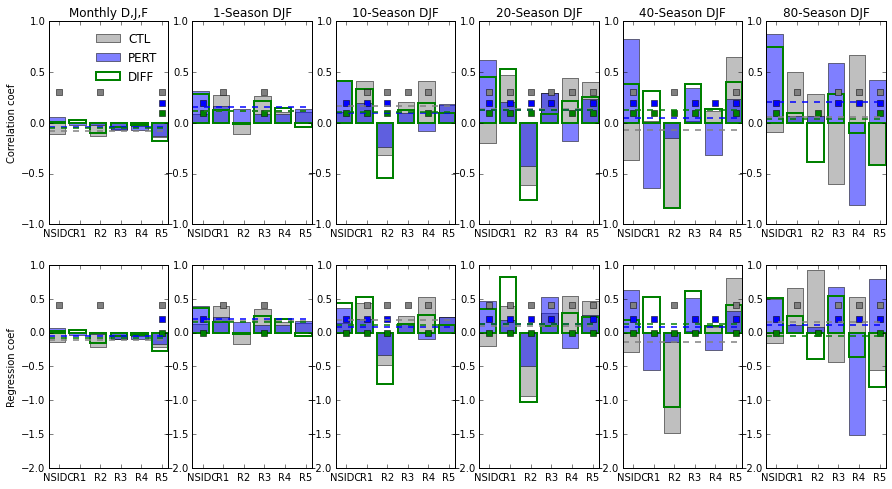

In [18]:
printtofile=True


print c_pmo
print c_psea

#regylims=(-3,2) # for kug regions
regylims=(-2,1) # for my regions (mori)
corylims=(-1,1)

coff=0.1
incr=0.2

xax=np.arange(0,len(sims))+.5
sig = np.ones(len(sims))*incr

print printtofile

fig,axs = plt.subplots(2,6,figsize=(15,8))

ax=axs[0,0] # first row
csigm=ma.masked_where(c_pmo>0.05,sig)
psigm=ma.masked_where(p_pmo>0.05,sig)
dsigm=ma.masked_where(d_pmo>0.05,sig)
b1=ax.bar(np.arange(0,len(sims)), c_rmo, color='0.5',alpha=0.5)
b2=ax.bar(np.arange(0,len(sims)), p_rmo, color='b',alpha=0.5)
b3=ax.bar(np.arange(0,len(sims)), d_rmo, color='None',edgecolor='g',linewidth=2)
ax.set_xticks(np.arange(0,len(sims))+.5)
ax.set_xticklabels(bkssatcdf.columns)
ax.set_ylabel('Correlation coef')
ax.set_title('Monthly D,J,F')
ax.plot(xax,csigm+coff,marker='s',linestyle='none',color='0.5')
ax.plot(xax,psigm,marker='s',linestyle='none',color='b')
ax.plot(xax,dsigm-coff,marker='s',linestyle='none',color='g')
ax.axhline(c_rmo.mean(),color='0.5',linewidth=1.5,linestyle='--')
ax.axhline(p_rmo.mean(),color='b',linewidth=1.5,linestyle='--')
ax.axhline(d_rmo.mean(),color='g',linewidth=1.5,linestyle='--')
ax.legend((b1,b2,b3),('CTL','PERT','DIFF'),loc='best',frameon=False)
ax.set_ylim(corylims)


coff=0.2

ax=axs[1,0] # second row
ax.bar(np.arange(0,len(sims)), cmmmo, color='0.5',alpha=0.5)
ax.bar(np.arange(0,len(sims)), pmmmo, color='b',alpha=0.5)
ax.bar(np.arange(0,len(sims)), dmmmo, color='None',edgecolor='g',linewidth=2)
ax.set_xticks(np.arange(0,len(sims))+.5)
ax.set_xticklabels(bkssatcdf.columns)
ax.set_ylabel('Regression coef')
ax.plot(xax,csigm+coff,marker='s',linestyle='none',color='0.5')
ax.plot(xax,psigm,marker='s',linestyle='none',color='b')
ax.plot(xax,dsigm-coff,marker='s',linestyle='none',color='g')
ax.axhline(cmmmo.mean(),color='0.5',linewidth=1.5,linestyle='--')
ax.axhline(pmmmo.mean(),color='b',linewidth=1.5,linestyle='--')
ax.axhline(dmmmo.mean(),color='g',linewidth=1.5,linestyle='--')
ax.set_ylim(regylims)

for ii,win in enumerate(runs):

    coff=0.1
    
    ax=axs[0,ii+1] # first row
    csigm=ma.masked_where(c_p[win]>0.05,sig)
    psigm=ma.masked_where(p_p[win]>0.05,sig)
    dsigm=ma.masked_where(d_p[win]>0.05,sig)
    ax.bar(np.arange(0,len(sims)), c_r[win], color='0.5',alpha=0.5)
    ax.bar(np.arange(0,len(sims)), p_r[win], color='b',alpha=0.5)
    ax.bar(np.arange(0,len(sims)), d_r[win], color='None',edgecolor='g',linewidth=2)
    ax.set_xticks(np.arange(0,len(sims))+.5)
    ax.set_xticklabels(bkssatcdf.columns)
    #ax.set_ylabel('Correlation coef')
    ax.set_title(str(win) + '-Season DJF')
    ax.plot(xax,csigm+coff,marker='s',linestyle='none',color='0.5')
    ax.plot(xax,psigm,marker='s',linestyle='none',color='b')
    ax.plot(xax,dsigm-coff,marker='s',linestyle='none',color='g')
    ax.axhline(c_r[win].mean(),color='0.5',linewidth=1.5,linestyle='--')
    ax.axhline(p_r[win].mean(),color='b',linewidth=1.5,linestyle='--')
    ax.axhline(d_r[win].mean(),color='g',linewidth=1.5,linestyle='--')
    ax.set_ylim(corylims)

    coff=0.2

    ax=axs[1,ii+1] # second row
    ax.bar(np.arange(0,len(sims)), cmm[win], color='0.5',alpha=0.5)
    ax.bar(np.arange(0,len(sims)), pmm[win], color='b',alpha=0.5)
    ax.bar(np.arange(0,len(sims)), dmm[win], color='None',edgecolor='g',linewidth=2)
    ax.set_xticks(np.arange(0,len(sims))+.5)
    ax.set_xticklabels(bkssatcdf.columns)
    #ax.set_ylabel('Regression coef')
    ax.plot(xax,csigm+coff,marker='s',linestyle='none',color='0.5')
    ax.plot(xax,psigm,marker='s',linestyle='none',color='b')
    ax.plot(xax,dsigm-coff,marker='s',linestyle='none',color='g')
    ax.axhline(cmm[win].mean(),color='0.5',linewidth=1.5,linestyle='--')
    ax.axhline(pmm[win].mean(),color='b',linewidth=1.5,linestyle='--')
    ax.axhline(dmm[win].mean(),color='g',linewidth=1.5,linestyle='--')
    ax.set_ylim(regylims)

if printtofile:
    fig.savefig('myreg_' + sims[0][0] + '_AGCMsims_bkseursat_regcorrcoefs_mon_sea_running.pdf')

In [17]:
regionskug

{'BKS': 'bksmori', 'CHUCK': 'chuckkug', 'EUR': 'eurasiamori', 'NA': 'nthamkug'}

nyr 119
remclimo.shape (3, 2)
remclimot.shape (357, 2)
nyr 119
remclimo.shape (3, 2)
remclimot.shape (357, 2)
nyr 119
remclimo.shape (3, 2)
remclimot.shape (357, 2)
nyr 119
remclimo.shape (3, 2)
remclimot.shape (357, 2)
2 ens: raw: regress bks sat and eur sat, monthly D,J,F
(array([-0.10755397, -0.15458436]), array([-16.33045245, -17.61497457]), array([-0.25104125, -0.40844338]), array([  1.55687058e-06,   8.71162283e-16]))
(array([-0.14244388, -0.12173368]), array([-16.48915912, -16.6216006 ]), array([-0.34386461, -0.27782348]), array([  2.40399486e-11,   9.48484874e-08]))
2 ens: remove monthly climo: regress bks sat and eur sat, monthly D,J,F
(array([-0.19226812, -0.2373013 ]), array([ -1.72305819e-17,   9.45477286e-17]), array([-0.41985607, -0.55651477]), array([  1.11910841e-16,   2.02593457e-30]))
(array([-0.23569103, -0.25106177]), array([  3.00992191e-19,  -1.63459004e-16]), array([-0.44081024, -0.4339586 ]), array([  2.09810326e-18,   7.93926823e-18]))
(357, 2)


(0, 360)

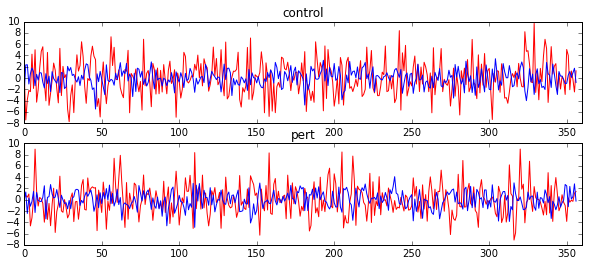

In [144]:

print '2 ens: raw: regress bks sat and eur sat, monthly D,J,F'
print cutl.regress(bkssatcmon,eursatcmon)
print cutl.regress(bkssatpmon,eursatpmon)
print '2 ens: remove monthly climo: regress bks sat and eur sat, monthly D,J,F'
print cutl.regress(bkssatcmonrem,eursatcmonrem)
print cutl.regress(bkssatpmonrem,eursatpmonrem)

print bkssatcmon.shape

fig,axs = plt.subplots(2,1,figsize=(10,4))
ax=axs[0] 
ax.plot(bkssatcmonrem[:,0],'r')
ax.plot(eursatcmonrem[:,0],'b')
ax.set_title('control')
ax.set_xlim((0,360))

ax=axs[1] 
ax.plot(bkssatpmonrem[:,0],'r')#,linestyle='--')
ax.plot(eursatpmonrem[:,0],'b')#,linestyle='--')
ax.set_title('pert')
ax.set_xlim((0,360))
